<a href="https://colab.research.google.com/github/GasanaElysee12/Geometric-Deep-Learning/blob/main/Elysee_GDL100_Practical1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
print(torch.__version__)

1.12.0+cu113


#GDL100 Practical 1: Geometric Deep Learning 2022


Welcome to practical 1 of the AMMI course on geometric deep learning. We have seen the equations and theory of graph representation learning in the lectures, so the aim of this practical is to further consolidate this in code. 

Through the practical we will look at:
- Reviewing notation for graphs and looking at the differences in node/edge level learning tasks and graph-level learning tasks.
- Taking a tour from implementing and applying feed forward MLPs to implementing a convolutional graph layer exploring semi-supervised node prediction.
- Moving to graph-level prediction and the challenges of batching observations that are graphs.
- Studying the expressive power of GNNs on different graphs. 

Doing so we will also familiarise ourselves with the various challenges involved in implementing GNNs, the various graph learning tasks and working with graph structured data.

**Here are the authors**: Please contact us for any questions regarding the notebook. \\

* Cristian Bodnar (cb2015@cam.ac.uk) \\
* Iulia Duta (id366@cam.ac.uk) \\
* Paul Scherer (pms69@cam.ac.uk)

\\

# Installation

In [ ]:
#@title [RUN] Install required libraries

!pip install networkx

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

!pip install mycolorpy
!pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!git clone --recurse-submodules https://github.com/dmlc/dgl.git

fatal: destination path 'dgl' already exists and is not an empty directory.


In [ ]:
!git submodule update --init --recursive

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
#@title [RUN] Import modules
import numpy as np
import seaborn as sns
import math
import itertools
import scipy as sp
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric
from torch_geometric.datasets import Planetoid, ZINC, GNNBenchmarkDataset
from torch_scatter import scatter_mean, scatter_max, scatter_sum
from torch_geometric.utils import to_dense_adj
from torch.nn import Embedding

import pdb

#for nice visualisations
import networkx as nx
import matplotlib.pyplot as plt

from mycolorpy import colorlist as mcp
import matplotlib.cm as cm

from typing import Mapping, Tuple, Sequence, List
import colorama

import scipy.linalg
from scipy.linalg import block_diag

In [ ]:
# @title [RUN] Helper functions for plots and visualisations

####### VISUALISATIONS #######

def draw_one_graph(ax, edges, label=None, node_emb=None, layout=None, special_color=False):
    """draw a graph with networkx based on adjacency matrix (edges)
    graph labels could be displayed as a title for each graph
    node_emb could be displayed in colors
    """
    graph = nx.Graph()
    edges = zip(edges[0], edges[1])
    graph.add_edges_from(edges)
    node_pos = layout(graph)
    #add colors according to node embeding
    if (node_emb is not None) or special_color:
        color_map = []
        node_list = [node[0] for node in graph.nodes(data = True)]
        for i,node in enumerate(node_list):
            #just ignore this branch
            if special_color:
                if len(node_list) == 3:
                    crt_color = (1,0,0)
                elif len(node_list) == 5:
                    crt_color = (0,1,0)
                elif len(node_list) == 4:
                    crt_color = (1,1,0)
                else:
                  special_list = [(1,0,0)] * 3 + [(0,1,0)] * 5 + [(1,1,0)] * 4
                  crt_color = special_list[i]
            else:
                crt_node_emb = node_emb[node]
                #map float number (node embeding) to a color
                crt_color = cm.gist_rainbow(crt_node_emb, bytes=True)
                crt_color = (crt_color[0]/255.0, crt_color[1]/255.0, crt_color[2]/255.0, crt_color[3]/255.0)
            color_map.append(crt_color)
      
        nx.draw_networkx_nodes(graph,node_pos, node_color=color_map,
                        nodelist = node_list, ax=ax)
        nx.draw_networkx_edges(graph, node_pos, ax=ax)
        nx.draw_networkx_labels(graph,node_pos, ax=ax)
    else:
        nx.draw_networkx(graph, node_pos, ax=ax)

def gallery(graphs, labels=None, node_emb=None, special_color=False, max_graphs=4, max_fig_size=(40, 10), layout=nx.layout.kamada_kawai_layout):
    ''' Draw multiple graphs as a gallery 
    Args:
      graphs: torch_geometrics.dataset object/ List of Graph objects
      labels: num_graphs
      node_emb: num_graphs* [num_nodes x num_ch]
      max_graphs: maximum graphs display
    '''
    num_graphs = min(len(graphs), max_graphs)
    ff, axes = plt.subplots(1, num_graphs,
                            figsize=max_fig_size,
                            subplot_kw={'xticks': [], 'yticks': []})
    if num_graphs == 1:
        axes = [axes]
    if node_emb is None:
        node_emb = num_graphs*[None]
    if labels is None:
        labels = num_graphs * [" "]


    for i in range(num_graphs):
        draw_one_graph(axes[i], graphs[i].edge_index.numpy(), labels[i], node_emb[i], layout, special_color)
        if labels[i] != " ":
            axes[i].set_title(f"Target: {labels[i]}", fontsize=28)
        axes[i].set_axis_off()
    plt.show()

def hash_node_embedings(node_emb):
  """ 
  This function is a basic, non-bijective one for visualising the embedings. 
  Please use it for guidance, not as a mathematical proof in Part 3.
  It is used just for educational/visualisation purpose.
  You are free to change it with whatever suits you best.
  Hash the tensor representing nodes' features 
  to a number in [0,1] used to represent a color

  Args:
    node_emb: list of num_graphs arrays, each of dim (num_nodes x num_feats)
  Returns:
    list of num_graphs arrays in [0,1], each of dim (num_nodes) 
  """
  chunk_size_graph = [x.shape[0] for x in node_emb]
  start_idx_graph = [0] + list(itertools.accumulate(chunk_size_graph))[:-1]

  node_emb_flatten = np.concatenate(node_emb).mean(-1)

  min_emb = node_emb_flatten.min()
  max_emb = node_emb_flatten.max()
  node_emb_flatten = (node_emb_flatten-min_emb)/(max_emb-min_emb++0.00001)

  #split in graphs again according to (start_idx_graph, chunk_size_graph)
  node_emb_hashed = [node_emb_flatten[i:i+l] for (i,l) in zip(start_idx_graph, chunk_size_graph)]
  return node_emb_hashed

####### PLOTS #######

def update_stats(training_stats, epoch_stats):
    """ Store metrics along the training
    Args:
      epoch_stats: dict containg metrics about one epoch
      training_stats: dict containing lists of metrics along training
    Returns:
      updated training_stats
    """
    if training_stats is None:
        training_stats = {}
        for key in epoch_stats.keys():
            training_stats[key] = []
    for key,val in epoch_stats.items():
        training_stats[key].append(val)
    return training_stats

def plot_stats(training_stats, figsize=(5, 5), name=""):
    """ Create one plot for each metric stored in training_stats
    """
    stats_names = [key[6:] for key in training_stats.keys() if key.startswith('train_')]
    f, ax = plt.subplots(len(stats_names), 1, figsize=figsize)
    if len(stats_names)==1:
        ax = np.array([ax])
        
    for key, axx in zip(stats_names, ax.reshape(-1,)):
        axx.plot(
            training_stats['epoch'],
            training_stats[f'train_{key}'],
            label=f"Training {key}")
        axx.plot(
            training_stats['epoch'],
            training_stats[f'val_{key}'],
            label=f"Validation {key}")
        axx.set_xlabel("Training epoch")
        axx.set_ylabel(key)
        axx.legend()
    plt.title(name)


def get_color_coded_str(i, color):
    return "\033[3{}m{}\033[0m".format(int(color), int(i))

def print_color_numpy(map, list_graphs):
    """ print matrix map in color according to list_graphs
    """
    list_blocks = []
    for i,graph in enumerate(list_graphs):
        block_i = (i+1)*np.ones((graph.num_nodes,graph.num_nodes))
        list_blocks += [block_i]
    block_color = block_diag(*list_blocks)
    
    map_modified = np.vectorize(get_color_coded_str)(map, block_color)
    print("\n".join([" ".join(["{}"]*map.shape[0])]*map.shape[1]).format(*[x for y in map_modified.tolist() for x in y]))
  

# Preliminaries on graphs and notation

As described in the lectures a graph is mathematical structure which defines a set of entities which are related in some way. Graphs contain *nodes* or *vertices* representing said entities with related nodes being connected by an *edge* or *link* that records the relation. 

Mathematically we can define simple graph as an ordered tuple $\mathcal{G} = (V, E)$ where $V$ is a set of nodes (or vertices) and $E \subseteq (V \times V$) is a 2-tuple set of the edges in the graph. Hence if $u$ and $v$ are nodes in $\mathcal{G}$, their relation is recorded with edge as $(u,v) \in E$ if the edge is directed from $u$ to $v$. The neighbours of a node $u$ is the set of nodes which share an edge with $u$, denoted $\mathcal{N}(u) = \{v | (u, v) \in E\}$. 

Edges can be directed or undirected. Directed edges are uni-directional relations from a source node $u$ and target node $v$ recorded as $(u,v) \in E$ and importantly $(u,v) \neq (v,u)$. Undirected edges are bi-directional and hence $(u,v) == (v,u)$. 

Graphs can be represented nicely by matrices. For a graph with $n$ nodes, $A \in \mathbb{R}^{n \times n}$ is a symmetric adjacency matrix where is $a_{i,j}$ is the weight of the edge between nodes $v_i$ and $v_j$. If $(v_i, v_j) \notin E$ then $a_{i,j} = 0$. A diagonal degree matrix $D \in \mathbb{R}^{n \times n}$ is defined as the matrix where each entry on the diagonal is the row-sum of the adjacency matrix. Note that this gives us what we need to define the Laplacian matrix of the graph $L = D-A$. For graphs with node features, each node $v_i \in V$ has an associated $d$-dimensional feature vector $\mathbf{x_i} \in \mathbb{R}^{d}$. Then the feature matrix $\mathbf{X} \in \mathbb{R}^{n \times d}$ can be used to represent the feature vectors for every node in the graph. Can you think of how edge feature matrix would be defined?

# Machine learning on graph structured data with GNNs

Machine learning tasks on graph structured data can be categorised based on the nuanced differences of the dataset and the task being studied. Most generally we are interested in the following tasks

- **Node prediction:** a data observation is a node within a graph, we are interested in doing node classification/regression. Ex. Cora dataset where we are interested in categorising papers that are nodes of a larger citation network
- **Edge prediction:** we are interested in predicting edges between samples in the dataset.
- **Graph level prediction:** a data observation is a graph, i.e. our dataset consists of graphs and we are interested in graph classification/regression. Ex. ZINC dataset where we are interested in predicting the solubility of each molecule/graph in the dataset

To motivate GNNs we will briefly look at the Cora dataset and node level learning. Following this we will look at graph level prediction as this will involve batching approaches that are likely different from what you are accustomed to.

# Part 1: A first look at Cora

A now classic dataset for GNNs (one whose use is also discouraged within some circles as it is very easy to overfit on), Cora is a nice small dataset to start looking at GNNs. There are many variations of the Cora dataset originally presented in "Automating the Construction of Internet Portals with Machine Learning" by McCallum et al. (https://link.springer.com/article/10.1023/A:1009953814988). 

We will use the Cora dataset variant as presented in “FastGCN: Fast Learning with Graph Convolutional Networks via Importance Sampling” (https://arxiv.org/abs/1801.10247). It describes a citation network of 2708 papers and our task is classify each paper into one of 7 different categories. Some quick facts of this Cora variant:


*   There are 2708 papers (i.e. observations in the dataset)
  * 1208 train
  * 500 validation
  * 1000 test
*   Each paper is represented by a 1433 dimensional bag-of-words vector
*   Each paper belongs to one of 7 classes

Ignoring GNNs for a moment, our first attempt would be to use a simple model such as a feed forward MLP. In fact, it's always good practice to explore the task with simpler models for debugging and benchmarking. 

We will work with the cora dataset through a `CoraDataset` object which will download the dataset and provides the following methods:

- `train_val_test_split(self)`: returns torch tensors for `train_x`, `train_y`, `validation_x`, `validation_y`, `test_x`, `test_y`, corresponding to input x and target y for each of the train/val/test splits.
- `get_fullx(self)`: returns the feature matrix $\mathbf{X} \in \mathbb{R}^{|V| \times d}$ where $V$ is the set of nodes and $d$ the feature vector dimensionality.
- `get_adjacency_matrix(self)`: As the name suggests, returns a dense adjacency matrix $\mathbf{A}$

In [ ]:
# @title [RUN] `CoraDataset` implementation
# Let's get the Planetoid Cora dataset from 
# “FastGCN: Fast Learning with Graph Convolutional 
# Networks via Importance Sampling” (https://arxiv.org/abs/1801.10247)

from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj

class CoraDataset(object):
    def __init__(self):
        super(CoraDataset, self).__init__()
        cora_pyg = Planetoid(root='/tmp/Cora', name='Cora', split="full")
        self.cora_data = cora_pyg[0]
        self.train_mask = self.cora_data.train_mask
        
        
        self.valid_mask = self.cora_data.val_mask
        self.test_mask = self.cora_data.test_mask

    def train_val_test_split(self):
        train_x = self.cora_data.x[self.cora_data.train_mask]
        train_y = self.cora_data.y[self.cora_data.train_mask]

        valid_x = self.cora_data.x[self.cora_data.val_mask]
        valid_y = self.cora_data.y[self.cora_data.val_mask]

        test_x = self.cora_data.x[self.cora_data.test_mask]
        test_y = self.cora_data.y[self.cora_data.test_mask]
        return train_x, train_y, valid_x, valid_y, test_x, test_y

    def get_fullx(self):
        return self.cora_data.x

    def get_adjacency_matrix(self):
        # We will ignore this for the first part
        adj = to_dense_adj(self.cora_data.edge_index)[0]
        return adj

In [ ]:
# Lets download our cora dataset and get the splits
cora_data = CoraDataset()
train_x, train_y, valid_x, valid_y, test_x, test_y = cora_data.train_val_test_split()

# Always check and confirm our data shapes match our expectations
print(f"Train shape x: {train_x.shape}, y: {train_y.shape}")
print(f"Val shape x: {valid_x.shape}, y: {valid_y.shape}")
print(f"Test shape x: {test_x.shape}, y: {test_y.shape}")

Train shape x: torch.Size([1208, 1433]), y: torch.Size([1208])
Val shape x: torch.Size([500, 1433]), y: torch.Size([500])
Test shape x: torch.Size([1000, 1433]), y: torch.Size([1000])


In [ ]:
# @title [RUN] Hyperparameters MLP

NUM_EPOCHS =  100 #@param {type:"integer"}
LR         = 0.001 #@param {type:"number"}

#you can add more here if you need


In [ ]:
# Lets implement a simple feed forward MLP
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class SimpleMLP(nn.Module):
 
    """A simple feed forward neural network with no hidden layers

    Args:
        input_dim (int): Dimensionality of the input feature vectors
        output_dim (int): Dimensionality of the output softmax distribution
    """
    def __init__(self, input_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.layer_1 = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.layer_1(x)
        # y_hat = F.log_softmax(x, dim=1) <- old version
        y_hat = x
        return y_hat

In [ ]:
# Lets define some utility functions for training and computing performance metrics
# and then see how our model does!
def train_mlp_cora(x, y, model, optimiser):
    model.train()
    optimiser.zero_grad()
    y_hat = model(x)
    loss = F.cross_entropy(y_hat, y)
    loss.backward()
    optimiser.step()
    return loss.data

def evaluate_mlp_cora(x, y, model):
    model.eval()
    y_hat = model(x)
    y_hat = y_hat.data.max(1)[1]
    num_correct = y_hat.eq(y.data).sum()
    num_total = len(y)
    accuracy = 100.0 * (num_correct/num_total)
    return accuracy

def train_eval_loop(model, train_x, train_y, valid_x, valid_y, test_x, test_y):
    optimiser = optim.Adam(model.parameters(), lr=LR)
    training_stats = None
    # Training loop
    for epoch in range(NUM_EPOCHS):
        train_loss = train_mlp_cora(train_x, train_y, model, optimiser)
        train_acc = evaluate_mlp_cora(train_x, train_y, model)
        valid_acc = evaluate_mlp_cora(valid_x, valid_y, model)
        if epoch % 10 == 0:
            print(f"Epoch {epoch} with train loss: {train_loss:.3f} train accuracy: {train_acc:.3f}",
                    f"validation accuracy: {valid_acc:.3f}")
        # store the loss and the accuracy for the final plot
        epoch_stats = {'train_acc': train_acc, 'val_acc': valid_acc, 'epoch':epoch}
        training_stats = update_stats(training_stats, epoch_stats)
    # Lets look at our final test performance
    test_acc = evaluate_mlp_cora(test_x, test_y, model)
    print(f"Our final test accuracy for the SimpleMLP is: {test_acc:.3f}")
    return training_stats

Epoch 0 with train loss: 1.949 train accuracy: 19.205 validation accuracy: 18.400
Epoch 10 with train loss: 1.812 train accuracy: 56.705 validation accuracy: 46.000
Epoch 20 with train loss: 1.687 train accuracy: 63.907 validation accuracy: 49.800
Epoch 30 with train loss: 1.574 train accuracy: 69.619 validation accuracy: 51.600
Epoch 40 with train loss: 1.470 train accuracy: 74.421 validation accuracy: 53.400
Epoch 50 with train loss: 1.375 train accuracy: 79.636 validation accuracy: 56.000
Epoch 60 with train loss: 1.288 train accuracy: 84.023 validation accuracy: 58.200
Epoch 70 with train loss: 1.207 train accuracy: 86.341 validation accuracy: 60.600
Epoch 80 with train loss: 1.134 train accuracy: 88.659 validation accuracy: 61.400
Epoch 90 with train loss: 1.066 train accuracy: 90.563 validation accuracy: 62.200
Our final test accuracy for the SimpleMLP is: 65.100


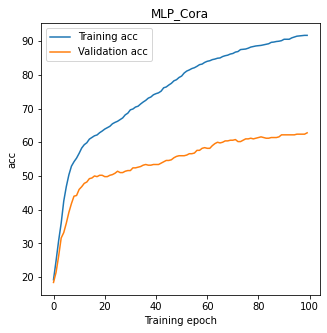

In [ ]:
# Instantiate our model 
model = SimpleMLP(input_dim=train_x.shape[-1], output_dim=7)

# Run training loop
train_stats_mlp_cora = train_eval_loop(model, train_x, train_y, valid_x, valid_y, test_x, test_y)
plot_stats(train_stats_mlp_cora, name="MLP_Cora")

We should be getting final test accuracies of around 65% on Cora for an extremely simple MLP model. Not too bad!

But are we using all the information/data available to us and can we do better with it?

# Our first GNN layer

On our application of the MLP on Cora we have completely ignored the fact that Cora is a citation *network*! In Cora citations form undirected edges between each of the nodes (papers) in this network. We think this additional information can be useful for categorising our papers, but how can we incorporate this structure in a neural network layer? 

In lectures 3-4 we were introduced to a general blue-print for creating GNN layers. We can build GNN layers $\mathbf{F(X,A)}$ on graphs via the shared application of local permutation invariant $\phi(\mathbf{x_i}, \mathbf{X}_{\mathcal{N}_i})$. The various implementations of $\phi$ is the subject of much research, for our purpose we will start by considering GNN layers with constant values for the convolution coefficients. 



Generic GNN Layer of the "convolutional" flavour. We are interested in developing a layer that uses set parameters for $c_{i,j}, (i,j) \in E$

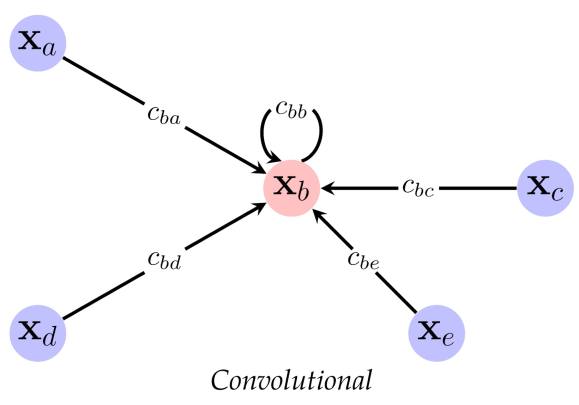












Generic equation for convolutional GNN:
$$
\mathbf{h_i} = \phi \big(\mathbf{x_i}, \oplus_{j \in \mathcal{N}_i} c_{i,j} \psi (\mathbf{x_j}) \big)
$$

Getting more specific, let us look at the GCN from Kipf and Welling's "Semi-Supervised Classification with Graph Convolutional Networks" (https://arxiv.org/abs/1609.02907). This employs a symmetric normalisation for the convolution coefficients with a re-normalisation to tackle exploding parameters.

$$
\mathbf{H} = \sigma \big( \mathbf{\tilde{D}}^{-\frac{1}{2}} \mathbf{\tilde{A}} \mathbf{\tilde{D}}^{-\frac{1}{2}} \mathbf{X} \mathbf{W} \big)
$$

Where $\mathbf{\tilde{A}} = \mathbf{A} + \mathbf{I}$ and $\mathbf{\tilde{D}}$ is the degree matrix of $\mathbf{\tilde{A}}$.

### 💻**Task 1.1**  Define $c_{i,j}$, $\oplus_{j \in \mathcal{N}_i}$ and $\phi$ _mathematically_ so that the behaviour of the generic, convolutional GNN layer is the same as a GCN. (0.5 Marks)

$\oplus_{j \in \mathcal{N}_i}$: This is any permutation invariant such as $\sum_{j \in \mathcal{N}_i}$

* $C_{ij}=\frac{1}{\sqrt{d_u}}\frac{1}{\sqrt{d_v}}$, $d_i:$ is the degree of node $i$ and $d_j:$ is the degree of node $j$ 

$\phi$ is the aggregating function as sum, invariant pooling.




In [ ]:
adjacent=np.array([[1,2],[9,8]])
adjacent[1,1]

8

Write your answer here



### 💻**Task 1.2** Implement the GCNLayer given the above equation. (1.0 Mark)

In [ ]:
# @title [RUN] Hyperparameters GNN

NUM_EPOCHS =  100 #@param {type:"integer"}
LR         = 0.01 #@param {type:"number"}

#you can add more here if you need

In [ ]:
# Fill in initialisation and forward method the GCNLayer below
class GCNLayer(nn.Module):
    """GCN layer to be implemented by students of practical

    Args:
        input_dim (int): Dimensionality of the input feature vectors
        output_dim (int): Dimensionality of the output softmax distribution
        A (torch.Tensor): 2-D adjacency matrix
    """
    def __init__(self, input_dim, output_dim, A):
        super(GCNLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.A = A

        # ============ YOUR CODE HERE =============
        # Compute symmetric norm
        
        identity=torch.eye(self.A.shape[0])
        # A\truder  
         

        self.adjacent=self.A+identity
        # self.D=torch.zeros((self.adjacent.shape[0],self.adjacent.shape[0]))
        self.D=torch.diag(torch.sum(self.adjacent,dim=1))

        self.D_inv=torch.pow(self.D,-0.5)
        self.D_inv[torch.isinf(self.D_inv)] = 0.0

        self.adj_norm = self.D_inv@self.adjacent@self.D_inv
        # + Simple linear transformation and non-linear activation
        self.linear =nn.Linear(self.input_dim,self.output_dim)
        #Compute the weights
        self.weight=self.linear.weight.data

        # print('weihhh',self.weight.shape)
        # self.relu=nn.ReLU()
        # self.output=nn.Linear(self.output,4)
        # self.softmax=nn.Softmax()
        # =========================================

    def forward(self, x):
      
      output=self.adj_norm@x

      H=self.linear(output)
        # ============ YOUR CODE HERE =============
        # x = ...
        # =========================================
      return F.relu(H)


# Semi-supervised learning: Transductive vs Inductive 

Notice that we use the entire adjacency and node feature matrix each time we call the GCNLayer as opposed to the specific subsets of the train/validation/test we did earlier with the MLP. This is because nodes from the different splits share edges with those from the other splits and building our representation requires these. Hence, the learning performed with our GCNLayer is an instance of *transductive semi-supervised learning* as the model gets to see all of the observations in the dataset. This is different to the *inductive* learning performed on the MLP where the model only sees the train observations during training and only sees validation/test observations for prediction. **Hint for one of the tasks** It is important to note that despite the model using all of the observations and entire adjacency matrix it does not use all of the targets!

### 💻**Task 1.3** Look at the code below and the usage of the various `<split>_mask`s. What are they doing to the outputs of the GCNLayer, and why are they important? (0.5 Marks)

Give your answer here
* Train_mask: is the train nodes set.

* Validation_mask: Validation nodes set.

* Test_mask: Test nodes set.




In [ ]:
 # Lets see the GCNLayer in action!
class SimpleGNN(nn.Module):
    """Simple GNN model using the GCNLayer implemented by students

    Args:
        input_dim (int): Dimensionality of the input feature vectors
        output_dim (int): Dimensionality of the output softmax distribution
        A (torch.Tensor): 2-D adjacency matrix
    """
    def __init__(self, input_dim, output_dim, A):
        super(SimpleGNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.A = A
        self.gcn_layer = GCNLayer(input_dim, output_dim, A)

    def forward(self, x):
        x = self.gcn_layer(x)
        # y_hat = F.log_softmax(x, dim=1) <- old version
        y_hat = x
        return y_hat

def train_gnn_cora(X, y, mask, model, optimiser):
    model.train()
    optimiser.zero_grad()
    y_hat = model(X)[mask]
    loss = F.cross_entropy(y_hat, y)
    loss.backward()
    optimiser.step()
    return loss.data

def evaluate_gnn_cora(X, y, mask, model):
    model.eval()
    y_hat = model(X)[mask]
    y_hat = y_hat.data.max(1)[1]
    num_correct = y_hat.eq(y.data).sum()
    num_total = len(y)
    accuracy = 100.0 * (num_correct/num_total)
    return accuracy
    
# Training loop
def train_eval_loop_gnn_cora(model, train_x, train_y, train_mask, 
                        valid_x, valid_y, valid_mask, 
                        test_x, test_y, test_mask
                    ):
    optimiser = optim.Adam(model.parameters(), lr=LR)
    training_stats = None
    # Training loop
    for epoch in range(NUM_EPOCHS):
        train_loss = train_gnn_cora(train_x, train_y, train_mask, model, optimiser)
        train_acc = evaluate_gnn_cora(train_x, train_y, train_mask, model)
        valid_acc = evaluate_gnn_cora(valid_x, valid_y, valid_mask, model)
        if epoch % 10 == 0:
            print(f"Epoch {epoch} with train loss: {train_loss:.3f} train accuracy: {train_acc:.3f} validation accuracy: {valid_acc:.3f}")
        # store the loss and the accuracy for the final plot
        epoch_stats = {'train_acc': train_acc, 'val_acc': valid_acc, 'epoch':epoch}
        training_stats = update_stats(training_stats, epoch_stats)
    # Lets look at our final test performance
    test_acc = evaluate_gnn_cora(test_x, test_y, test_mask, model)
    print(f"Our final test accuracy for the SimpleGNN is: {test_acc:.3f}")
    return training_stats

Epoch 0 with train loss: 1.947 train accuracy: 43.791 validation accuracy: 38.800
Epoch 10 with train loss: 1.383 train accuracy: 72.930 validation accuracy: 68.000
Epoch 20 with train loss: 0.900 train accuracy: 92.301 validation accuracy: 83.000
Epoch 30 with train loss: 0.588 train accuracy: 94.785 validation accuracy: 85.800
Epoch 40 with train loss: 0.415 train accuracy: 95.778 validation accuracy: 86.800
Epoch 50 with train loss: 0.318 train accuracy: 96.689 validation accuracy: 86.600
Epoch 60 with train loss: 0.257 train accuracy: 97.351 validation accuracy: 86.200
Epoch 70 with train loss: 0.215 train accuracy: 98.262 validation accuracy: 85.600
Epoch 80 with train loss: 0.184 train accuracy: 98.841 validation accuracy: 85.600
Epoch 90 with train loss: 0.160 train accuracy: 98.924 validation accuracy: 85.400
Our final test accuracy for the SimpleGNN is: 84.000


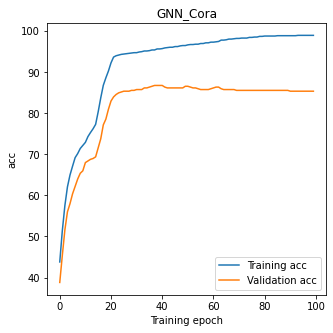

In [ ]:

# Instantiate our model and optimiser
A = cora_data.get_adjacency_matrix()
X = cora_data.get_fullx()
model = SimpleGNN(input_dim=train_x.shape[-1], output_dim=7, A=A)

train_mask = cora_data.train_mask
valid_mask = cora_data.valid_mask
test_mask = cora_data.test_mask

# Run training loop
train_stats_gnn_cora = train_eval_loop_gnn_cora(model, X, train_y, train_mask, 
                                          X, valid_y, valid_mask, 
                                          X, test_y, test_mask
                                       )
plot_stats(train_stats_gnn_cora, name="GNN_Cora")

Alright we got quite the boost here, seeing final test performances of about 84% despite no change to the number of trainable parameters being used. Neat!

### 💻**Task 1.4** In your own words describe why our GCNLayer outperforms the SimpleMLP despite having the same number of parameters? What are the positives and drawbacks? (0.5 Marks)

Since the data are not many Graph Convolutional Network Layer is overfitting the data. It also uses the graph information that helps the model to improve the prediction. Small hidden size, special batching were used when we are sampling the connected subgraph of the original graph.

The Graph Convolutional Network Layer(GCNlayer) is one of the basic graph network architectures. It is repeatedly applied to different parts of a larger input while traversing the input and also applied to the neighborhoods around a node in a graph.

The positive drawback it can help to separate different embedding for small dataset. But, it is not good if we have a big dataset. Generalization is not good due to the fact that it overfits the data.



Fill in the answer here


### 💻**Task 1.5** Explore enlargening the receptive field visible to the computation of $\mathbf{H}$. First, how can this be done? Does this help? Try implementing this and observing the effect of increasing the receptive field of your GNN on performance.  (0.5 Marks)

Fill in the answer here


In [ ]:
# Try coding it out here!

# Lets see the GCNLayer in action!
class SimpleGNN(nn.Module):
    """Simple GNN model using the GCNLayer implemented by students

    Args:
        input_dim (int): Dimensionality of the input feature vectors
        output_dim (int): Dimensionality of the output softmax distribution
        A (torch.Tensor): 2-D adjacency matrix
    """
    def __init__(self, input_dim, output_dim, A):
        super(SimpleGNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.A = A
        self.gcn_layer1 = GCNLayer(input_dim, output_dim, A)
        self.gcn_layer2 = GCNLayer(output_dim, output_dim, A)

    def forward(self, x):
        x = self.gcn_layer1(x)
        x=self.gcn_layer2(x)
        # y_hat = F.log_softmax(x, dim=1) <- old version
        y_hat = x
        return y_hat

def train_gnn_cora(X, y, mask, model, optimiser):
    model.train()
    optimiser.zero_grad()
    y_hat = model(X)[mask]
    loss = F.cross_entropy(y_hat, y)
    loss.backward()
    optimiser.step()
    return loss.data

def evaluate_gnn_cora(X, y, mask, model):
    model.eval()
    y_hat = model(X)[mask]
    y_hat = y_hat.data.max(1)[1]
    num_correct = y_hat.eq(y.data).sum()
    num_total = len(y)
    accuracy = 100.0 * (num_correct/num_total)
    return accuracy
    
# Training loop
def train_eval_loop_gnn_cora(model, train_x, train_y, train_mask, 
                        valid_x, valid_y, valid_mask, 
                        test_x, test_y, test_mask
                    ):
    optimiser = optim.Adam(model.parameters(), lr=LR)
    training_stats = None
    # Training loop
    for epoch in range(NUM_EPOCHS):
        train_loss = train_gnn_cora(train_x, train_y, train_mask, model, optimiser)
        train_acc = evaluate_gnn_cora(train_x, train_y, train_mask, model)
        valid_acc = evaluate_gnn_cora(valid_x, valid_y, valid_mask, model)
        if epoch % 10 == 0:
            print(f"Epoch {epoch} with train loss: {train_loss:.3f} train accuracy: {train_acc:.3f} validation accuracy: {valid_acc:.3f}")
        # store the loss and the accuracy for the final plot
        epoch_stats = {'train_acc': train_acc, 'val_acc': valid_acc, 'epoch':epoch}
        training_stats = update_stats(training_stats, epoch_stats)
    # Lets look at our final test performance
    test_acc = evaluate_gnn_cora(test_x, test_y, test_mask, model)
    print(f"Our final test accuracy for the SimpleGNN is: {test_acc:.3f}")
    return training_stats

tensor([ True,  True,  True,  ..., False, False, False])
training torch.Size([2708])
tensor([   0,    1,    2,  ..., 1705, 1706, 1707])
validing torch.Size([2708])
testing torch.Size([2708])
Epoch 0 with train loss: 1.942 train accuracy: 28.311 validation accuracy: 31.600
Epoch 10 with train loss: 1.572 train accuracy: 55.464 validation accuracy: 55.600
Epoch 20 with train loss: 1.149 train accuracy: 64.901 validation accuracy: 62.400
Epoch 30 with train loss: 0.838 train accuracy: 72.020 validation accuracy: 68.800
Epoch 40 with train loss: 0.694 train accuracy: 73.179 validation accuracy: 69.400
Epoch 50 with train loss: 0.626 train accuracy: 74.089 validation accuracy: 69.800
Epoch 60 with train loss: 0.588 train accuracy: 74.669 validation accuracy: 69.600
Epoch 70 with train loss: 0.564 train accuracy: 75.000 validation accuracy: 69.200
Epoch 80 with train loss: 0.546 train accuracy: 75.579 validation accuracy: 69.000
Epoch 90 with train loss: 0.534 train accuracy: 75.745 validati

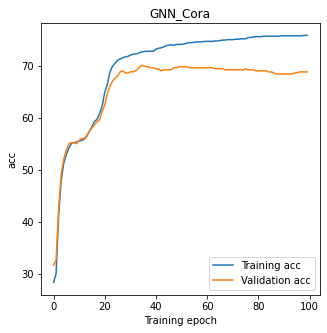

In [ ]:
# Instantiate our model and optimiser
A = cora_data.get_adjacency_matrix()
X = cora_data.get_fullx()
model = SimpleGNN(input_dim=train_x.shape[-1], output_dim=7, A=A)

train_mask = cora_data.train_mask
print(train_mask)
print('training',train_mask.shape)
valid_mask = cora_data.valid_mask
print(sum(torch.where(train_mask==True)))
print('validing',valid_mask.shape)
test_mask = cora_data.test_mask
print('testing',test_mask.shape)
# Run training loop
train_stats_gnn_cora = train_eval_loop_gnn_cora(model, X, train_y, train_mask, 
                                          X, valid_y, valid_mask, 
                                          X, test_y, test_mask
                                       )
plot_stats(train_stats_gnn_cora, name="GNN_Cora")

### 💻**Task 1.6** Considering why the GCNLayer improves the performance, what change can be made to the Cora network so that the GCNLayer would lose significant performance below the MLP. Implement this change and explain your work. (1.0 Marks)

Fill in your text answer here


In [ ]:
def Reduce_nodes(m):
  m=m.numpy()
  i=0
  for k in range(len(m)):
    if m[k]==True:
      i+=1
    if i>725:
    # if k>=2:
      m[k]=False

 
  
  return m

In [ ]:
def Increase_nodes(m):
  m=m.numpy()
  i=0
  for k in range(len(m)):
    if m[k]==True:
      i+=1
    if i<1520:
    # if k>=2:
      m[k]=True

 
  
  return m

In [ ]:

from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj

class CoraDataset(object):
    def __init__(self):
        super(CoraDataset, self).__init__()
        cora_pyg = Planetoid(root='/tmp/Cora', name='Cora', split="full")
        self.cora_data = cora_pyg[0]
        self.train_mask = Reduce_nodes(self.cora_data.train_mask)
        
        
        self.valid_mask = self.cora_data.val_mask
        self.test_mask = self.cora_data.test_mask

    def train_val_test_split(self):
        train_x = self.cora_data.x[self.cora_data.train_mask]
        train_y = self.cora_data.y[self.cora_data.train_mask]

        valid_x = self.cora_data.x[self.cora_data.val_mask]
        valid_y = self.cora_data.y[self.cora_data.val_mask]

        test_x = self.cora_data.x[self.cora_data.test_mask]
        test_y = self.cora_data.y[self.cora_data.test_mask]
        return train_x, train_y, valid_x, valid_y, test_x, test_y

    def get_fullx(self):
        return self.cora_data.x

    def get_adjacency_matrix(self):
        # We will ignore this for the first part
        adj = to_dense_adj(self.cora_data.edge_index)[0]
        return adj

#Increase the nodes

In [ ]:

class CoraDataset(object):
    def __init__(self):
        super(CoraDataset, self).__init__()
        cora_pyg = Planetoid(root='/tmp/Cora', name='Cora', split="full")
        self.cora_data = cora_pyg[0]
        self.train_mask = Reduce_nodes(self.cora_data.train_mask)
        
        
        self.valid_mask = self.cora_data.val_mask
        self.test_mask = Increase_nodes(self.cora_data.test_mask)

    def train_val_test_split(self):
        train_x = self.cora_data.x[self.cora_data.train_mask]
        train_y = self.cora_data.y[self.cora_data.train_mask]

        valid_x = self.cora_data.x[self.cora_data.val_mask]
        valid_y = self.cora_data.y[self.cora_data.val_mask]

        test_x = self.cora_data.x[self.cora_data.test_mask]
        test_y = self.cora_data.y[self.cora_data.test_mask]
        return train_x, train_y, valid_x, valid_y, test_x, test_y

    def get_fullx(self):
        return self.cora_data.x

    def get_adjacency_matrix(self):
        # We will ignore this for the first part
        adj = to_dense_adj(self.cora_data.edge_index)[0]
        return adj

In [ ]:
# Lets download our cora dataset and get the splits
cora_data = CoraDataset()
train_x, train_y, valid_x, valid_y, test_x, test_y = cora_data.train_val_test_split()

# Always check and confirm our data shapes match our expectations
print(f"Train shape x: {train_x.shape}, y: {train_y.shape}")
print(f"Val shape x: {valid_x.shape}, y: {valid_y.shape}")
print(f"Test shape x: {test_x.shape}, y: {test_y.shape}")

Train shape x: torch.Size([725, 1433]), y: torch.Size([725])
Val shape x: torch.Size([500, 1433]), y: torch.Size([500])
Test shape x: torch.Size([2708, 1433]), y: torch.Size([2708])


In [ ]:
# Lets see the GCNLayer in action!
class SimpleGNN(nn.Module):
    """Simple GNN model using the GCNLayer implemented by students

    Args:
        input_dim (int): Dimensionality of the input feature vectors
        output_dim (int): Dimensionality of the output softmax distribution
        A (torch.Tensor): 2-D adjacency matrix
    """
    def __init__(self, input_dim, output_dim, A):
        super(SimpleGNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.A = A
        self.gcn_layer1 = GCNLayer(input_dim, output_dim, A)
        self.gcn_layer2= GCNLayer(output_dim, output_dim, A)

    def forward(self, x):
        x = self.gcn_layer1(x)
        x = self.gcn_layer2(x)
        # y_hat = F.log_softmax(x, dim=1) <- old version
        y_hat = x
        return y_hat

def train_gnn_cora(X, y, mask, model, optimiser):
    model.train()
    optimiser.zero_grad()
    y_hat = model(X)[mask]
    loss = F.cross_entropy(y_hat, y)
    loss.backward()
    optimiser.step()
    return loss.data

def evaluate_gnn_cora(X, y, mask, model):
    model.eval()
    y_hat = model(X)[mask]
    y_hat = y_hat.data.max(1)[1]
    num_correct = y_hat.eq(y.data).sum()
    num_total = len(y)
    accuracy = 100.0 * (num_correct/num_total)
    return accuracy
    
# Training loop
def train_eval_loop_gnn_cora(model, train_x, train_y, train_mask, 
                        valid_x, valid_y, valid_mask, 
                        test_x, test_y, test_mask
                    ):
    optimiser = optim.Adam(model.parameters(), lr=LR)
    training_stats = None
    # Training loop
    for epoch in range(NUM_EPOCHS):
        train_loss = train_gnn_cora(train_x, train_y, train_mask, model, optimiser)
        train_acc = evaluate_gnn_cora(train_x, train_y, train_mask, model)
        valid_acc = evaluate_gnn_cora(valid_x, valid_y, valid_mask, model)
        if epoch % 10 == 0:
            print(f"Epoch {epoch} with train loss: {train_loss:.3f} train accuracy: {train_acc:.3f} validation accuracy: {valid_acc:.3f}")
        # store the loss and the accuracy for the final plot
        epoch_stats = {'train_acc': train_acc, 'val_acc': valid_acc, 'epoch':epoch}
        training_stats = update_stats(training_stats, epoch_stats)
    # Lets look at our final test performance
    test_acc = evaluate_gnn_cora(test_x, test_y, test_mask, model)
    print(f"Our final test accuracy for the SimpleGNN is: {test_acc:.3f}")
    return training_stats

[ True  True  True ... False False False]
training (2708,)
validing torch.Size([2708])
testing (2708,)
Epoch 0 with train loss: 1.909 train accuracy: 29.655 validation accuracy: 33.800
Epoch 10 with train loss: 1.523 train accuracy: 50.897 validation accuracy: 48.800
Epoch 20 with train loss: 1.096 train accuracy: 70.069 validation accuracy: 71.200
Epoch 30 with train loss: 0.795 train accuracy: 76.828 validation accuracy: 73.800
Epoch 40 with train loss: 0.636 train accuracy: 82.207 validation accuracy: 75.200
Epoch 50 with train loss: 0.555 train accuracy: 84.276 validation accuracy: 76.800
Epoch 60 with train loss: 0.509 train accuracy: 86.483 validation accuracy: 76.800
Epoch 70 with train loss: 0.481 train accuracy: 88.000 validation accuracy: 76.600
Epoch 80 with train loss: 0.463 train accuracy: 88.276 validation accuracy: 76.400
Epoch 90 with train loss: 0.451 train accuracy: 89.655 validation accuracy: 76.400
Our final test accuracy for the SimpleGNN is: 79.505


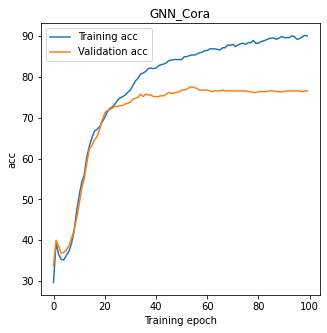

In [ ]:
# Instantiate our model and optimiser
A = cora_data.get_adjacency_matrix()
X = cora_data.get_fullx()
model = SimpleGNN(input_dim=train_x.shape[-1], output_dim=7, A=A)

train_mask = cora_data.train_mask
print(train_mask)
print('training',train_mask.shape)
valid_mask = cora_data.valid_mask

print('validing',valid_mask.shape)
test_mask = cora_data.test_mask
print('testing',test_mask.shape)
# Run training loop
train_stats_gnn_cora = train_eval_loop_gnn_cora(model, X, train_y, train_mask, 
                                          X, valid_y, valid_mask, 
                                          X, test_y, test_mask
                                       )
plot_stats(train_stats_gnn_cora, name="GNN_Cora")

In [ ]:
# Try coding it out here!

# CHECK FOR MLP

In [ ]:
class SimpleMLP(nn.Module):
 
    """A simple feed forward neural network with no hidden layers

    Args:
        input_dim (int): Dimensionality of the input feature vectors
        output_dim (int): Dimensionality of the output softmax distribution
    """
    def __init__(self, input_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.layer_1 = nn.Linear(input_dim, output_dim)
        self.layer_2 = nn.Linear(output_dim, output_dim)

    def forward(self, x):
        x = self.layer_1(x)
        x=self.layer_2(x)
        # y_hat = F.log_softmax(x, dim=1) <- old version
        y_hat = x
        return y_hat

In [ ]:
def train_mlp_cora(x, y, model, optimiser):
    model.train()
    optimiser.zero_grad()
    y_hat = model(x)
    loss = F.cross_entropy(y_hat, y)
    loss.backward()
    optimiser.step()
    return loss.data

def evaluate_mlp_cora(x, y, model):
    model.eval()
    y_hat = model(x)
    y_hat = y_hat.data.max(1)[1]
    num_correct = y_hat.eq(y.data).sum()
    num_total = len(y)
    accuracy = 100.0 * (num_correct/num_total)
    return accuracy

def train_eval_loop(model, train_x, train_y, valid_x, valid_y, test_x, test_y):
    optimiser = optim.Adam(model.parameters(), lr=LR)
    training_stats = None
    # Training loop
    for epoch in range(NUM_EPOCHS):
        train_loss = train_mlp_cora(train_x, train_y, model, optimiser)
        train_acc = evaluate_mlp_cora(train_x, train_y, model)
        valid_acc = evaluate_mlp_cora(valid_x, valid_y, model)
        if epoch % 10 == 0:
            print(f"Epoch {epoch} with train loss: {train_loss:.3f} train accuracy: {train_acc:.3f}",
                    f"validation accuracy: {valid_acc:.3f}")
        # store the loss and the accuracy for the final plot
        epoch_stats = {'train_acc': train_acc, 'val_acc': valid_acc, 'epoch':epoch}
        training_stats = update_stats(training_stats, epoch_stats)
    # Lets look at our final test performance
    test_acc = evaluate_mlp_cora(test_x, test_y, model)
    print(f"Our final test accuracy for the SimpleMLP is: {test_acc:.3f}")
    return training_stats

Epoch 0 with train loss: 1.947 train accuracy: 25.241 validation accuracy: 21.600
Epoch 10 with train loss: 1.081 train accuracy: 74.483 validation accuracy: 54.200
Epoch 20 with train loss: 0.551 train accuracy: 90.483 validation accuracy: 61.000
Epoch 30 with train loss: 0.253 train accuracy: 97.379 validation accuracy: 64.000
Epoch 40 with train loss: 0.119 train accuracy: 98.897 validation accuracy: 65.200
Epoch 50 with train loss: 0.066 train accuracy: 99.586 validation accuracy: 64.200
Epoch 60 with train loss: 0.042 train accuracy: 99.862 validation accuracy: 63.800
Epoch 70 with train loss: 0.030 train accuracy: 99.862 validation accuracy: 63.600
Epoch 80 with train loss: 0.022 train accuracy: 100.000 validation accuracy: 63.400
Epoch 90 with train loss: 0.017 train accuracy: 100.000 validation accuracy: 62.800
Our final test accuracy for the SimpleMLP is: 72.267


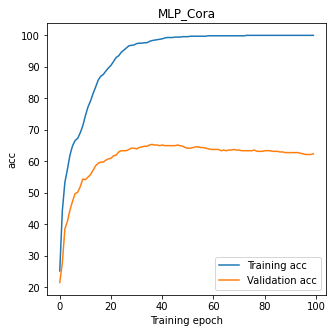

In [ ]:
# Instantiate our model 
model = SimpleMLP(input_dim=train_x.shape[-1], output_dim=7)

# Run training loop
train_stats_mlp_cora = train_eval_loop(model, train_x, train_y, valid_x, valid_y, test_x, test_y)
plot_stats(train_stats_mlp_cora, name="MLP_Cora")

# By reducing the ratio of training and increase the test set, the value of MLP and GCN accuracy increased. But, when Increased both number of layers on GCN and MLP the accuracy of GCN has fallen down under MLP.

## Moving on to graph level prediction
Great you've covered the basics of GNN layer development and studying node level prediction.

Now lets look at graph level prediction. Consider the differences: we are no longer looking at each observation being a node (typically represented by an associated feature vector) but now each observation is an entire graph! As we do so we run into our first challenge: how do we batch graphs that can come in different sizes?

# Part 2: Graph-level prediction

In the previous section, you trained a Graph Neural Network for node-level prediction. Let's move to a graph-level task to understand **what changes you should make in the architecture** and **what are some limitations of classical models**. 

For this, we will use [ZINC](https://arxiv.org/abs/1610.02415). ZINC is a dataset for graph-regression. It contains about 12 000 molecular graphs with up to 38 nodes each and the task is to predict for each molecule the solubility (a scalar number).

Let's load the dataset using the [torch_geometric.dataset](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.ZINC) and check what it contains:

In [ ]:
train_zinc_dataset = ZINC(root='', split='train', subset=True)
val_zinc_dataset = ZINC(root='', split='val', subset=True)
test_zinc_dataset = ZINC(root='', split='test', subset=True)

print(f"\nTrain examples: {len(train_zinc_dataset)}")
print(f"Val examples: {len(val_zinc_dataset)}")
print(f"Test examples: {len(test_zinc_dataset)}\n")

one_graph = train_zinc_dataset[0]

print(f"First graph contains {one_graph.x.shape[0]} nodes, each characterised by {one_graph.x.shape[1]} features")
print(f"Graph labels have shape: {one_graph.y.shape}")


Extracting ./molecules.zip
Processing...
Processing test dataset: 100%|██████████| 1000/1000 [00:00<00:00, 10756.89it/s]


Train examples: 10000
Val examples: 1000
Test examples: 1000

First graph contains 29 nodes, each characterised by 1 features
Graph labels have shape: torch.Size([1])



Done!


To store information about each graph, we create the following ` Graph` class. Note that, instead of storing an entire adjacency matrix to describe the graph structure, we will store it more efficiently as a list of edges of shape `[2, num_edges]`.  

Note: `*_zinc_dataset` loads above are not instances of Graph structure, but their structure [torch_geometric.Data](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data) is a lot similar to that one.



In [ ]:
class Graph(object):
    def __init__(self, edge_index, x, y):
        """ Graph structure 
            for a mini-batch it will store a big (sparse) graph 
            representing the entire batch
        Args:
            x: node features  [num_nodes x num_feats]
            y: graph labels   [num_graphs]
            edge_index: list of edges [2 x num_edges]
        """
        self.edge_index = edge_index
        self.x = x.to(torch.float32)
        self.y = y
        self.num_nodes = self.x.shape[0]

    #ignore this for now, it will be useful for batching
    def set_batch(self, batch):
        """ list of ints that maps each node to the graph it belongs to
            e.g. for batch = [0,0,0,1,1,1,1]: the first 3 nodes belong to graph_0 while
            the last 4 belong to graph_1
        """
        self.batch = batch

    # this function return a sparse tensor
    def get_adjacency_matrix(self):
        """ from the list of edges create 
        a num_nodes x num_nodes sparse adjacency matrix
        """
        return torch.sparse.LongTensor(self.edge_index, 
                              # we work with a binary adj containing 1 if an edge exist
                              torch.ones((self.edge_index.shape[1])), 
                              torch.Size((self.num_nodes, self.num_nodes))
                              )

Note that, for efficiency, the adjacency matrix (`self.get_adjacency_matrix()`) is stored as a sparse matrix (using `torch.sparse.LongTensor()`). This means that, instead of the entire matrix, we will only store the indexes of the vertices and the value (weight) corresponding to each edge. This saves lots of memory in storing the tensors for which the majority of elements are zeros.

If you need to convert a sparse tensor `x` into a dense one you can use `x.to_dense()`. Moreover, many operations are directly supported for sparse tensors via [torch.sparse](https://pytorch.org/docs/stable/sparse.html) (e.g. `torch.sparse.mm()` that multiplies a sparse matrix with a sparse/dense matrix).

Lets visualize the graphs using the `networkx` library. 

*Showing how to do this is out of the scope of this lab, so the function is entirely coded for you, but you can find out more about this from [here](https://networkx.org/documentation/stable/tutorial.html).*

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  """Entry point for launching an IPython kernel.


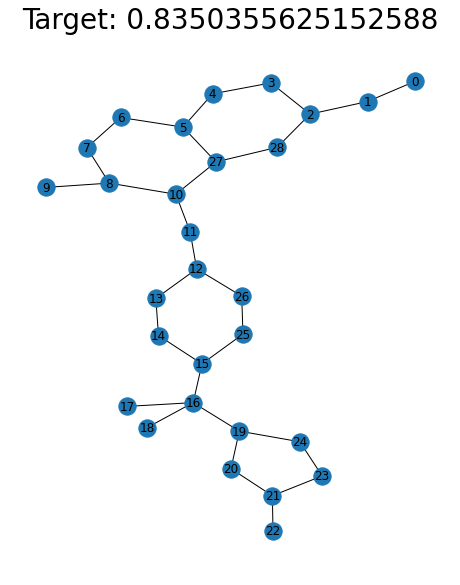

In [ ]:
gallery([one_graph], labels=np.array([one_graph.y]), max_fig_size=(8,10))

# Mini-batching for graph data

Since we are now dealing with multiple graphs, we need to figure out how to store them in mini-batches, to be able to make the computation as efficient as possible. For some types of data, stacking samples in mini-batches is a trivial task. For example, images of $32\times32$ pixels are easy to batch because they have the same dimension (obtaining a tensor of dimension $batch\_{size}\times32\times32$). On the other hand, graphs come in different sizes with adjacency matrices of different shapes:

In [ ]:
print(f'First graph : {train_zinc_dataset[0].x.shape} with adjacency {(train_zinc_dataset[0].num_nodes, train_zinc_dataset[0].num_nodes)}')
print(f'Second graph: {train_zinc_dataset[1].x.shape} with adjacency {(train_zinc_dataset[1].num_nodes, train_zinc_dataset[1].num_nodes)}')
print(f'Third graph : {train_zinc_dataset[2].x.shape} with adjacency {(train_zinc_dataset[2].num_nodes, train_zinc_dataset[2].num_nodes)}')


First graph : torch.Size([29, 1]) with adjacency (29, 29)
Second graph: torch.Size([26, 1]) with adjacency (26, 26)
Third graph : torch.Size([16, 1]) with adjacency (16, 16)


One solution for this is to create a single *sparse* graph as the union of all the graphs in the mini-batch as follow:

1. stack the features $x$ for all the nodes in all the graphs
2. stack the labels $y$ for all the nodes in all the graphs
3. stack all the adjacency matrices $A_i$ as diagonal blocks in the new adjacency matrix

This way, we will obtain a new graph containing $\sum_{i=1}^{B}|V_i|$ nodes, where $B$ is the batch_size and by $|V_i|$ we denote the number of nodes in graph $i$. Note that since **no** edges connect nodes from different graphs,  the  information propagation will not be affected by the way we store it.  

<center>
<img src="https://drive.google.com/uc?export=view&id=1RwI0CYA57S0OgLxgHgV6PBFNG9tnGvGR" width="500">
</center>

<center>
<img src="https://drive.google.com/uc?export=view&id=1Ux65wTJLXCfJ4TI4Up4mCHkaSja8NgrJ" width="500">
</center>


As you can see, the resulting matrix contains many zeros (sparse), thus our choice of storing the adjacency matrix as a sparse tensor can indeed bring us efficiency.

Until now, we have a way to store the graphs in a mini-batch such that they could be efficiently processed. 

However, we need to also be able to extract information from this structure, to recover the graphs that it contains. For this, we need to remember what initial graph each node belongs to.

We will do this by storing a list of indices `(self.batch)`, which map each node in the batch-graph to the initial graph it belong to. For example `batch=[0,0,0,1,1,2,2,2]` indicates that first 3 nodes belong to $G_0$, the next 2 nodes belong to $G_1$ and the last 3 nodes belong to $G_2$.



### 💻 **Task 2.1:** in the following you will have to implement the mini_batch function. (1.5 Marks)

In [ ]:
def create_mini_batch(graph_list: List[Graph]) -> Graph:
    """ Built a sparse graph from a batch of graphs
    Args:
        graph_list: list of Graph objects in a batch
    Returns:
        a big (sparse) Graph representing the entire batch
    """
    #insert first graph into the structure
    batch_edge_index = graph_list[0].edge_index
    batch_x = graph_list[0].x
    batch_y = graph_list[0].y
    batch_batch = torch.zeros((graph_list[0].num_nodes), dtype=torch.int64)
    # ============ YOUR CODE HERE =============
    # you may need additional variables
    # ==========================================
    nodes_list=graph_list[0].num_nodes
    #append the rest of the graphs to the structure
    for idx, graph in enumerate(graph_list[1:]):
        # ============ YOUR CODE HERE =============
        # concat the features
        batch_x =torch.cat((batch_x,graph.x))
        # concat the labels
        batch_y =torch.cat((batch_y,graph.y))
        
        # concat the adjacency matrix as a block diagonal matrix
        
        graph_edge_index_current=graph.edge_index+nodes_list
        # print(batch_edge_index.shape, graph_edge_index_current.shape)

        batch_edge_index =torch.cat((batch_edge_index,graph_edge_index_current), dim=1)
        nodes_list +=graph.num_nodes
        # ==========================================

        # ============ YOUR CODE HERE =============
        # create the array of indexes mapping nodes in the batch-graph
        # to the graph they belong to
        # specify the mapping between the new nodes and the graph they belong to (idx+1)
        b = (idx + 1)*torch.ones((graph.num_nodes), dtype=torch.int64)
        # print(batch_batch.shape, b.shape)
        batch_batch =torch.cat((batch_batch,b), dim=0)
        # ==========================================
        pass
    #create the big sparse graph 
    batch_graph = Graph(batch_edge_index, batch_x, batch_y)
    #attach the index array to the Graph structure
    batch_graph.set_batch(batch_batch)
    return batch_graph

Batch number_of_nodes: 12
Batch features shape: torch.Size([12, 32])
Batch labels shape: torch.Size([3])
Batch adjacency: 
1 1 1 0 0 0 0 0 0 0 0 0
1 1 1 0 0 0 0 0 0 0 0 0
1 1 1 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 1 1 0 0 0 0
0 0 0 1 0 1 1 1 0 0 0 0
0 0 0 1 0 0 0 1 0 0 0 0
0 0 0 1 0 0 0 0 0 0 0 0
0 0 0 1 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 1 0 0
0 0 0 0 0 0 0 0 0 0 1 0
0 0 0 0 0 0 0 0 0 0 0 1
0 0 0 0 0 0 0 0 1 0 0 0


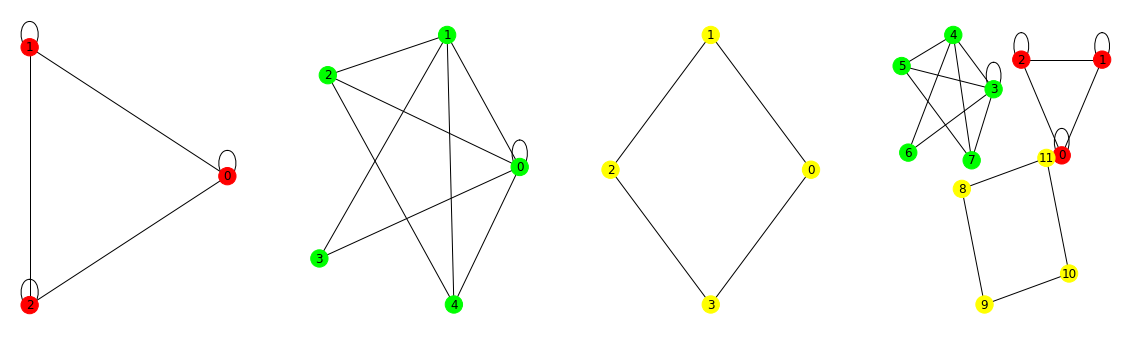

And we also have access to which graph each node belongs to tensor([0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2])



In [ ]:
#@title Visualize the mini-batching for a small list of batch_size=3 graphs.
# Note that the three graphs viusalized are directed, 
# so the adjacency matrix will be non-symmetric 
# (even if the visualisation depicted them as undirected)

# 3 random custom-designed graphs for visualisations
graph1 = Graph(x=torch.rand((3,32)), 
               y=torch.rand((1)), 
               edge_index=torch.tensor([[0,0,0,1,1,1,2,2,2],[0,1,2,0,1,2,0,1,2]]))
graph2 = Graph(x=torch.rand((5,32)), 
               y=torch.rand((1)), 
               edge_index=torch.tensor([[0,0,0,0,0,1,1,1,2,1,2,3,4], [0,1,2,3,4,2,3,4,4,0,0,0,0]]))
graph3 = Graph(x=torch.rand((4,32)),
               y=torch.rand((1)), 
              edge_index=torch.tensor([[0,1,2,3],[1,2,3,0]]))
list_graphs = [graph1, graph2, graph3]

# create a mini-batch from these 3 graphs
batch_sample = create_mini_batch(list_graphs)

# show statistics about the new graph built from this batch of graphs
print(f"Batch number_of_nodes: {batch_sample.num_nodes}")
print(f"Batch features shape: {batch_sample.x.shape}")
print(f"Batch labels shape: {batch_sample.y.shape}")

print(f"Batch adjacency: ")
print_color_numpy(batch_sample.get_adjacency_matrix().to_dense().numpy(), list_graphs)

gallery([graph1, graph2, graph3, batch_sample], max_fig_size=(20,6), special_color=True)
print(f"And we also have access to which graph each node belongs to {batch_sample.batch}\n")


# Scatter for aggregate information



As you learned in the course, a simple way of aggregating information from node-level representation to obtain graph-level predictions is by (max/mean/sum) pooling. This can be efficiently obtained using the [`torch_scatter`](https://pytorch-scatter.readthedocs.io/en/1.3.0/functions/mean.html) library containing operations such as `scatter_mean`, `scatter_max`, `scatter_sum`.

 `scatter_*` receives as input a tensor and an array of indices and pools the information in the tensor stored at the indices specified in the array.

Visualisation for `scatter_sum(array, index)`: 

\\

<!-- <center> -->
<img src="https://drive.google.com/uc?export=view&id=16E9Nyd-mPdYBWm923joWKJx4JR8c8pCz" width="300">
<!-- </center> -->

### 💻 **Task 2.2:** Having access to all the nodes embedings in a batch, use `scatter_*` to create a graph embedings for each graph in the batch (0.5 Marks)

In [ ]:
array = torch.tensor([13, 21, 3, 7, 11, 20, 2])
index = torch.tensor([0,1,1,0,2,0,1])

aggregate_sum = scatter_sum(array, index, dim=0)
aggregate_mean = scatter_mean(array, index, dim=0)
aggregate_max, aggregate_argmax = scatter_max(array, index, dim=0)

print("Let's inspect what different scatter functions compute: ")
print(f"sum aggregation: {aggregate_sum}")
print(f"mean aggregation: {aggregate_mean}")
print(f"max aggregation: {aggregate_max}\n")

batch_zinc = create_mini_batch(train_zinc_dataset[:3])
# ============ YOUR CODE HERE =============
# Given the nodes features for a batch of graphs (batch_zinc.x) 

# and the list of indices indicating what graph each node belongs to

# apply scatter_* to obtain a graph embedings for each graph in the batch
# You can play with all of them (scatter_mean/scatter_max/scatter_sum)

node_emb =batch_zinc.x
# node_set=torch.unique(node_emb)
# print('mmm',batch_zinc.edge_index[0])
# print(batch_zinc.x)
# bb={}
# for j in batch_zinc.edge_index:
  
#   for i in range(154):
#     bb[i]=[]
#     if i in j[i]:
#       bb[i].append(node_emb[i])
# print(bb)
node_batch = batch_zinc.batch 
graph_emb =scatter_sum(node_emb,node_batch,dim=0)
# ==========================================
print(node_emb.shape)
print(graph_emb.shape)


Let's inspect what different scatter functions compute: 
sum aggregation: tensor([40, 26, 11])
mean aggregation: tensor([13,  8, 11])
max aggregation: tensor([20, 21, 11])

torch.Size([71, 1])
torch.Size([3, 1])


✅ So until now we've learned 
1. how to store a batch of graphs in an efficient way
2. how scatter operations work and how to use it to extract graph-level representations from node-level representations. 

Let's integrate what we've learned so far in a Graph Neural Network model.

# Graph Neural Network for graph-level regression

In [ ]:
# @title [RUN] Hyperparameters GIN 

BATCH_SIZE = 128 #@param {type:"integer"}
NUM_EPOCHS =   30#@param {type:"integer"}
HIDDEN_DIM =   64#@param {type:"integer"}
LR         = 0.001 #@param {type:"number"}

#you can add more here if you need

We will design a  Graph Neural Network model, similar to the one used on Cora, with the following modifications:
* graph-level prediction instead of node-level prediction
* regression instead of classification
* to obtain *provable more powerful architecture* $^\dagger$, we will go beyond GCN Layer and implement a [**GIN Layer**](https://arxiv.org/abs/1810.00826) instead.

$^\dagger$*we will rigurously define what it means in the last section of the Practical*.

One simple instantiation of GIN Layer processes the graph according to the following message passing equation, where $\epsilon_k$ is a learnable scalar

\begin{equation}
X^{k+1}= \text{MLP}_k\big(AX^k + (1+\epsilon_k)X^k\big)
\end{equation}

### 💻 **Task 2.3:** Most of the code is provided to you, but you have to fill in the missing part that implements the core message passing equation shown above. (1 Mark)

In [ ]:
class GINLayer(nn.Module):
    """A single GIN layer, implementing MLP(AX + (1+eps)X)"""
    def __init__(self, in_feats: int, out_feats: int, hidden_dim: int, eps: float=0.0):
        super(GINLayer, self).__init__()
        self.in_feats = in_feats
        self.out_feats = out_feats
        # ============ YOUR CODE HERE =============
        # epsilon should be a learnable parameter
        self.eps = torch.nn.Parameter(torch.Tensor([eps])) 
        # =========================================
        self.linear1 = nn.Linear(self.in_feats, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, self.out_feats)

    def forward(self, x, adj_sparse): 
        # ============ YOUR CODE HERE =============
        # aggregate the neighbours as in GIN: (AX + (1+eps)X)
        x =torch.sparse.mm(adj_sparse,x)+(1+self.eps)*x
        
        # project the features (MLP_k)
        x=F.relu(self.linear1(x))
        out =self.linear2(x) 
        # =========================================
        return out
        a--1--b--4--c

Using the above GIN Layer, let's design a neural network with `num_layers` GINLayers, to solve the graph-regression task

### 💻 **Task 2.4:** The code is provided. All you have to do is to fill-in the code that creates graph-representations from node-representations (1 Mark)

In [ ]:
from torch.nn.modules.linear import Linear
class SimpleGIN(nn.Module):
    """ 
    A Graph Neural Network containing GIN layers 
    as in https://arxiv.org/abs/1810.00826 
    The readout function used to obtain graph-lvl representations
    is just the sum of the nodes in the graph

    Args:
        input_dim (int): Dimensionality of the input feature vectors
        output_dim (int): Dimensionality of the output softmax distribution
        num_layers (int): Number of layers
    """
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers=2, eps=0.0, 
                 molecular=True):
        super(SimpleGIN, self).__init__()
        self.num_layers = num_layers # please select num_layers>=2
        self.molecular = molecular
        # nodes in ZINC dataset are characterised by one integer (atom category)
        # we will create embeddings from the categorical features using nn.Embedding
        if self.molecular:
            self.embed_x = Embedding(28, hidden_dim)
        else:
            self.embed_x = Linear(input_dim, hidden_dim)

        # instead of nn.Linear as in SimpleMLP model, 
        # now we have (num_layers) GINLayer(s), each with different parameters
        self.layers = [GINLayer(hidden_dim, hidden_dim, hidden_dim, eps) for _ in range(num_layers-1)]
        self.layers += [GINLayer(hidden_dim, output_dim, hidden_dim, eps)]
        self.layers = nn.ModuleList(self.layers)
    
    def forward(self, graph):
        adj_sparse = graph.get_adjacency_matrix()
        if self.molecular:
            x = self.embed_x(graph.x.long()).squeeze(1)
        else:
            x = self.embed_x(graph.x)

        for i in range(self.num_layers-1):
          x = self.layers[i](x, adj_sparse)
          x = F.relu(x)
        x = self.layers[-1](x, adj_sparse)

        # ============ YOUR CODE HERE =============
        # graph-level representations are obtain by pooling info from the nodes using sum
        y_hat =scatter_sum(x,graph.batch,dim=0)
        # =========================================

        y_hat = y_hat.squeeze(-1)
        #return also the final node embeddings (for visualisations)
        return y_hat, x

Since now we have a proper graph network to play with, let's check if our mini-batch implementation is correct. For this, we provide an unit test checking that runing the code on individual graphs or directly on an entire batch provides the same results: 

In [ ]:
#@title [RUN] Unit test for mini-batch implementation
def unit_test_mini_batch(batch):
  model = SimpleGIN(input_dim=batch[0].x.size()[-1], output_dim=1, hidden_dim=HIDDEN_DIM, num_layers=4)

  graph_batch = create_mini_batch(batch)
  out_batch, _ = model(graph_batch)

  for i in range(BATCH_SIZE):
    batch_i = create_mini_batch([batch[i]])
    out_i, node_emb_i = model(batch_i)
    assert(np.abs(out_i.detach().numpy() - out_batch[i].detach().numpy()).mean() <1e-5 )
  print("Congrats 😊 !! Everything seems all right!")

In [ ]:
#@title Run unit test for mini-batch implementation
batch = train_zinc_dataset[:BATCH_SIZE]
unit_test_mini_batch(batch)

Congrats 😊 !! Everything seems all right!


In [ ]:
def train(dataset, model, optimiser, epoch, loss_fct, metric_fct, print_every):
    """ Train model for one epoch 
    """
    model.train()
    num_iter = int(len(dataset)/BATCH_SIZE)
    for i in range(num_iter):
        batch_list = dataset[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        batch = create_mini_batch(batch_list)
        optimiser.zero_grad()
        y_hat, _ = model(batch)
        loss = loss_fct(y_hat, batch.y)
        metric = metric_fct(y_hat, batch.y)
        loss.backward()
        optimiser.step() 
        if (i+1) % print_every == 0:
          print(f"Epoch {epoch} Iter {i}/{num_iter}",
                    f"Loss train {loss.data}; Metric train {metric.data}")
    return loss, metric

def evaluate(dataset, model, loss_fct, metrics_fct):
    """ Evaluate model on dataset
    """
    model.eval()
    # be careful in practice, as doing this way we will lose some 
    # examples from the validation split, when len(dataset)%BATCH_SIZE != 0
    # think about how can you fix this!
    num_iter = int(len(dataset)/BATCH_SIZE)
    metrics_eval = 0
    loss_eval = 0
    for i in range(num_iter):
        batch_list = dataset[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        batch = create_mini_batch(batch_list)
        y_hat, _ = model(batch)
        metrics = metrics_fct(y_hat, batch.y)
        loss = loss_fct(y_hat, batch.y)

        metrics_eval += metrics.data
        loss_eval += loss.data
    metrics_eval /= num_iter
    loss_eval /= num_iter
    return loss_eval, metrics_eval

In [ ]:
def train_eval(model, train_dataset, val_dataset, test_dataset, 
               loss_fct, metric_fct, print_every=1):
    """ Train the model for NUM_EPOCHS epochs
    """
    #Instantiatie our optimiser
    optimiser = optim.Adam(model.parameters(), lr=LR)
    training_stats = None

    #initial evaluation (before training)
    val_loss, val_metric = evaluate(val_dataset, model, loss_fct, metric_fct)
    train_loss, train_metric = evaluate(train_dataset[:BATCH_SIZE], model, 
                                        loss_fct, metric_fct)
    epoch_stats = {'train_loss': train_loss.detach().numpy(), 'val_loss': val_loss.detach().numpy(), 
                      'train_metric': train_metric.detach().numpy(), 'val_metric': val_metric.detach().numpy(), 
                      'epoch':0}
    training_stats = update_stats(training_stats, epoch_stats)

    for epoch in range(NUM_EPOCHS):
        if isinstance(train_dataset, list):
            random.shuffle(train_dataset)
        else:
            train_dataset.shuffle()
        train_loss, train_metric = train(train_dataset, model, optimiser, epoch, 
                                        loss_fct, metric_fct, print_every)
        val_loss, val_metric = evaluate(val_dataset, model, loss_fct, metric_fct)
        if epoch%5==0:
          print(f"[Epoch {epoch+1}]",
                      f"train loss: {train_loss:.3f} val loss: {val_loss:.3f}",
                      f"train metric: {train_metric:.3f} val metric: {val_metric:.3f}"
                )
        # store the loss and the computed metric for the final plot
        epoch_stats = {'train_loss': train_loss.detach().numpy(), 'val_loss': val_loss.detach().numpy(), 
                      'train_metric': train_metric.detach().numpy(), 'val_metric': val_metric.detach().numpy(), 
                      'epoch':epoch+1}
        training_stats = update_stats(training_stats, epoch_stats)

    test_loss, test_metric = evaluate(test_dataset, model,  loss_fct, metric_fct)
    print(f"Test metric: {test_metric:.3f}")
    return training_stats

Now it's time to train our model and enjoy the results. 

In [ ]:
# Instantiate our GIN model
model_simple_gin = SimpleGIN(input_dim=batch_zinc.x.size()[-1], output_dim=1, hidden_dim=HIDDEN_DIM, num_layers=4, eps=0.1)
out, _ = model_simple_gin(batch_zinc)
print(out.detach().numpy())

[-6.029582  -5.1259065 -3.139182 ]


[Epoch 1] train loss: 1.116 val loss: 1.880 train metric: 1.116 val metric: 1.880
[Epoch 6] train loss: 0.603 val loss: 1.509 train metric: 0.603 val metric: 1.509
[Epoch 11] train loss: 0.498 val loss: 1.416 train metric: 0.498 val metric: 1.416
[Epoch 16] train loss: 0.464 val loss: 1.386 train metric: 0.464 val metric: 1.386
[Epoch 21] train loss: 0.430 val loss: 1.353 train metric: 0.430 val metric: 1.353
[Epoch 26] train loss: 0.390 val loss: 1.306 train metric: 0.390 val metric: 1.306
Test metric: 1.226


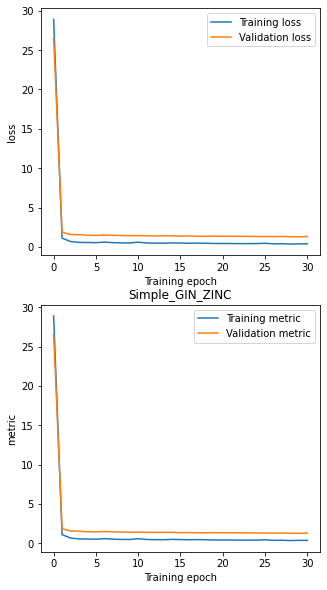

In [ ]:
#Train GIN model:
train_stats_simple_gin_zinc = train_eval(model_simple_gin, train_zinc_dataset, val_zinc_dataset, 
                                  test_zinc_dataset, loss_fct=F.mse_loss, 
                                  metric_fct=F.mse_loss, print_every=150)
plot_stats(train_stats_simple_gin_zinc, name='Simple_GIN_ZINC', figsize=(5, 10))

The full GIN architecture as introduced in the original [paper](https://arxiv.org/pdf/1810.00826.pdf), does not use only the final output for predictions. Instead, it creates a graph representation from the representation of all the intermediate layers:

\begin{equation}
h_G = CONCAT\big(\oplus_{v \in G}\{h_v^{(k)}\}| k=0,1..(K-1) \big)
\end{equation}

where $\oplus_{v \in G}\{h_v^{(k)}\}$ represents the graph-level representations at layer $k$, obtained by summing the representations from all the nodes $v \in G$

\\

### 💻 **Task 2.5:** Implement the entire architecture as described above. (1 Mark)

In [ ]:
class GIN(nn.Module):
  """ 
  A Graph Neural Network containing GIN layers 
  as in https://arxiv.org/abs/1810.00826 
  The readout function used to obtain graph-lvl representations
  aggregate pred from multiple layers (as in JK-Net)

  Args:
  input_dim (int): Dimensionality of the input feature vectors
  output_dim (int): Dimensionality of the output softmax distribution
  num_layers (int): Number of layers
  """
  def _init_(self, input_dim, output_dim, hidden_dim, num_layers=2, eps=0.0, \
                molecular=True):
      super(GIN, self)._init_()
      self.num_layers = num_layers 
      self.molecular = molecular
      # nodes in ZINC dataset are characterised by one integer (atom category)
      # we will create embeddings from the categorical features using nn.Embedding
      if self.molecular:
          self.embed_x = Embedding(28, hidden_dim)
      else:
          self.embed_x = Linear(input_dim, hidden_dim)

      # ============ YOUR CODE HERE =============
      
      # should be the same as before (an nn.ModuleList of GINLayers)
      self.layers = [GINLayer(hidden_dim, hidden_dim, hidden_dim, eps) for _ in range(num_layers-1)]
      self.layers += [GINLayer(hidden_dim, output_dim, hidden_dim, eps)]
      self.layers = nn.ModuleList(self.layers)

      # layer to compute prediction from the concatenated intermediate representations
      self.pred_layers =SimpleMLP(hidden_dim*(num_layers-1),output_dim)
     


      # =========================================

  def forward(self, graph):
      adj_sparse = graph.get_adjacency_matrix()
      if self.molecular:
          x = self.embed_x(graph.x.long()).squeeze(1)
      else:
          x = self.embed_x(graph.x)

      # ============ YOUR CODE HERE ============= 
      # perform the forward pass with the new readout function  
      final_concat=[]
      for i in range(self.num_layers-1):
          x = self.layers[i](x, adj_sparse)
          x = F.relu(x)
          
          aggreg=scatter_sum(x,graph.batch,dim=0)
          final_concat.append(aggreg)
      x=torch.cat(final_concat,axis=1)
     
        
        

     
      y_hat = self.pred_layers(x).squeeze(-1)
          # pass
      
      # =========================================
      # return also the final node embeddings (for visualisations)
      return y_hat, x

In [ ]:
model_gin = GIN(input_dim=batch_zinc.x.size()[-1], output_dim=1, hidden_dim=HIDDEN_DIM, num_layers=4, eps=0.1)
out, _ = model_gin(batch_zinc)
print(out.detach().numpy())

#Train GIN model:
train_stats_gin_zinc = train_eval(model_gin, train_zinc_dataset, val_zinc_dataset, 
                                  test_zinc_dataset, loss_fct=F.mse_loss, 
                                  metric_fct=F.mse_loss, print_every=150)
plot_stats(train_stats_gin_zinc, name='GIN_ZINC', figsize=(5, 10))

TypeError: ignored

In [ ]:
from torch.nn.modules.container import ModuleList
class GIN(nn.Module):
    """ 
    A Graph Neural Network containing GIN layers 
    as in https://arxiv.org/abs/1810.00826 
    The readout function used to obtain graph-lvl representations
    aggregate pred from multiple layers (as in JK-Net)

    Args:
    input_dim (int): Dimensionality of the input feature vectors
    output_dim (int): Dimensionality of the output softmax distribution
    num_layers (int): Number of layers
    """
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers=2, eps=0.0, \
                 molecular=True):
        super(GIN, self).__init__()
        self.num_layers = num_layers 
        self.molecular = molecular
        # nodes in ZINC dataset are characterised by one integer (atom category)
        # we will create embeddings from the categorical features using nn.Embedding
        if self.molecular:
            self.embed_x = Embedding(28, hidden_dim)
        else:
            self.embed_x = Linear(input_dim, hidden_dim)

        # ============ YOUR CODE HERE =============
        # should be the same as before (an nn.ModuleList of GINLayers)
        layer1=[GINLayer(hidden_dim, hidden_dim, hidden_dim, eps) for _ in range(num_layers-1)]
        layer1 += [GINLayer(hidden_dim, output_dim, hidden_dim, eps)]
        self.layers = nn.ModuleList(layer1)

        # layer to compute prediction from the concatenated intermediate representations
        self.pred_layers = SimpleMLP(output_dim,output_dim)
        # =========================================

    def forward(self, graph):
        adj_sparse = graph.get_adjacency_matrix()
        # print(adj_sparse.shape)
        if self.molecular:
            x = self.embed_x(graph.x.long()).squeeze(1)
        else:
            x = self.embed_x(graph.x)

        # ============ YOUR CODE HERE ============= 
        # perform the forward pass with the new readout function  
        aggreg_list=[]
        for i in range(self.num_layers-1):
            x = self.layers[i](x, adj_sparse)
            # print(x.shape)
            ss = F.relu(x)
            
        #     individual_aggreg=scatter_sum(ss,graph.batch,dim=0)
        #     print('indiv',individual_aggreg.shape)
        #     aggreg_list.append(individual_aggreg)
        # x=torch.cat(aggreg_list)
        # print('concar',x.shape)
        x = self.layers[-1](x, adj_sparse)
        # print('last layer',x.shape)
          
          

        x = self.pred_layers(x)

        # print('xxxxx',x.shape)
            # pass
        y_hat = scatter_sum(x,graph.batch,dim=0)
        pass
        # =========================================
        # return also the final node embeddings (for visualisations)
        return y_hat, x

[[21.234444]
 [18.193514]
 [11.499261]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Using a target size (

[Epoch 1] train loss: 4.293 val loss: 4.513 train metric: 4.293 val metric: 4.513
[Epoch 6] train loss: 4.221 val loss: 4.389 train metric: 4.221 val metric: 4.389
[Epoch 11] train loss: 3.818 val loss: 4.207 train metric: 3.818 val metric: 4.207
[Epoch 16] train loss: 3.778 val loss: 3.945 train metric: 3.778 val metric: 3.945
[Epoch 21] train loss: 3.782 val loss: 3.923 train metric: 3.782 val metric: 3.923
[Epoch 26] train loss: 3.781 val loss: 3.916 train metric: 3.781 val metric: 3.916
Test metric: 3.956


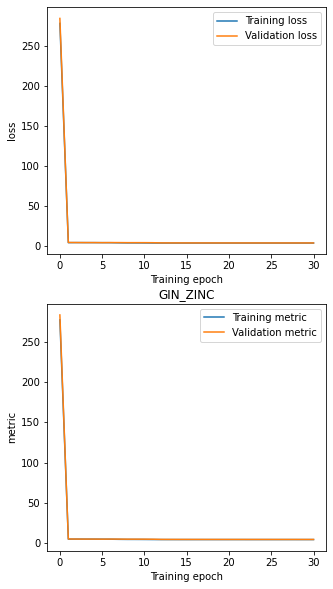

In [ ]:
model_gin = GIN(input_dim=batch_zinc.x.size()[-1], output_dim=1, hidden_dim=HIDDEN_DIM, num_layers=4, eps=0.1)
out, _ = model_gin(batch_zinc)
print(out.detach().numpy())

#Train GIN model:
train_stats_gin_zinc = train_eval(model_gin, train_zinc_dataset, val_zinc_dataset, 
                                  test_zinc_dataset, loss_fct=F.mse_loss, 
                                  metric_fct=F.mse_loss, print_every=150)
plot_stats(train_stats_gin_zinc, name='GIN_ZINC', figsize=(5, 10))

# Part 3: Expressive Power of Graph Neural Networks



You should be already confident that Graph Neural Networks represents powerful tools to process graph-data. However, there are some theoretically proven limitations that you should be aware of. From now on, your goal in this practical will be to **understand and overcome these limitations**.

In the following, we will look at 2 hard to distinguish  graphs and try to understand what are the problems that GNNs are not able to solve and why this happends.

In [ ]:
#@title [RUN] Hard to distinguish graphs
def gen_hard_graphs_WL():
  
  x1 = torch.ones((11,1))
  edge_index1 = torch.tensor([[1,3, 1, 2, 2, 3, 3, 3, 4, 4, 5, 5, 6, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10],
                 [2,3, 5, 1, 3, 2, 4, 6, 3, 5, 1, 4, 3, 7, 10, 6, 8, 7, 9, 8, 10, 6, 9]])-1
  y1 = torch.tensor([1])

  x2 = torch.ones((11,1))
  edge_index2 = torch.tensor([[1,4, 1, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10],
                 [2,3, 6, 1, 3, 7, 2, 4, 10, 3, 5, 4, 6, 1, 5, 2, 8, 7, 9, 8, 10, 3, 9]])-1
  y2 =  torch.tensor([2])  

  graph1 = Graph(x=x1, edge_index=edge_index1, y=y1)
  graph2 = Graph(x=x2, edge_index=edge_index2, y=y2)
  return [graph1, graph2]

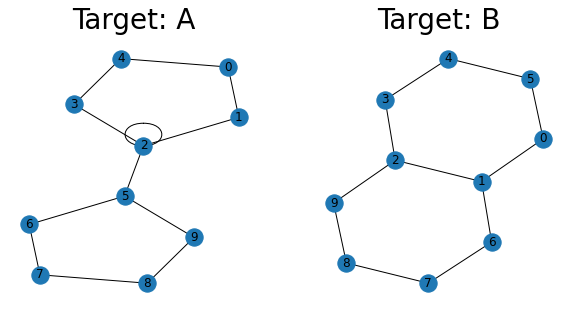

In [ ]:
hard_graphs = gen_hard_graphs_WL()
gallery(hard_graphs, labels=["A","B"], max_fig_size=(10,5))

Let's try to encode these graphs using our GIN Neural Network.

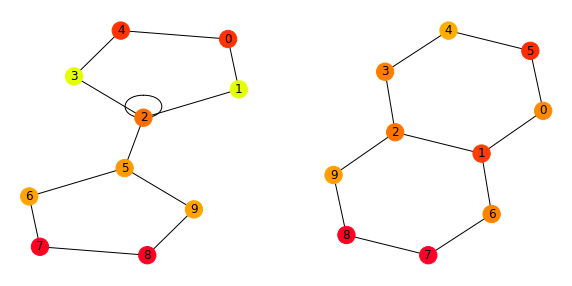

In [ ]:
hard_batch = create_mini_batch(hard_graphs)
out, node_emb = model_simple_gin(hard_batch)

#split node_emb from batch into separate graphs
node_emb = node_emb.detach().numpy()
node_emb_split=[node_emb[:hard_graphs[0].num_nodes], node_emb[hard_graphs[0].num_nodes:]]

#encode node representation into an int in [0,1] denoting the color
node_emb_split = hash_node_embedings(node_emb_split)


gallery(hard_graphs, node_emb=node_emb_split, max_fig_size=(10,5))


In the visualisation from above, the colors indicate the nodes embedings, as predicted by the model. Remember from the course that, to obtain a graph-level representation, we pool the nodes embedings using a *permutation invariant* function. This means that the multisets of colors determine the graph embeding. More exactly, if two graphs are encoded using the same multisets of colors, the final graph-representation will be the same.
This means that from the graph-level perspective the 2 graphs shown above are the same. However, for a human, it is obvious that this is not true.

**Why this is happening ❓**

Let's look at how the node embedings are computed by a 5-layer GNN.



<!-- <center> -->
<img src="https://drive.google.com/uc?export=view&id=1Jt6zJVApmgS9VFbcKpzxOoBtrxos55iu" width="1000">
<!-- </center> -->

If we are looking into how the computational network looks like for the two graphs in 5 steps, we observe that they essentially looks very similar. The **important** difference that we are able to spot, while the GNNs are not, is that, after 5 layers of propagation, in one graph (left) we reach the same note from where we've started, while in the other graph (right) we reach a different one. Since from the structure persective the 2 nodes are the same, the GNN will encode them the same without realising the difference between them. 

In the next section we will try to find how can we alleviate this and what could be the practical implications this problem raise.

# Improving the expressive power

As we have seen in the example above, GIN (and MPNNs in general) cannot distinguih any pair of non-isomorphic graphs. Based on this, we can devise a hierarchy of GNN models based on what pairs of graphs they can or cannot distinguish. 

**Definition.** *We say that a GNN model B is strictly more powerful than another model A if B can distinguish all the pairs of attributed graphs that A can distinguish and there exists a pair of attributed graphs that B can distiguish but A cannot.*

In this section, we are going to build a GNN model that is more powerful than GIN and design a synthetic task on which this can be evaluated emprically. Then, you will also be asked to prove mathematically that your model is indeed more powerful.

### 💻**Task 3.1:** Construct a graph classification or regression task where a model with superior expressive power should do better than GIN. Split your dataset in a training, validation and testing subsets. (1 Mark)

Hint: Try to find more examples of pairs of graphs that GIN cannot distiguish and generalise them into a dataset. 

In [ ]:
def Label():
  import string
  
  label=string.ascii_lowercase.upper()
  alp=[i for i in label]
  return alp

In [ ]:
def generate_dataset(n_graphs,n_nodes,degree):

  
  Graphs=[]
  graph_collection=[nx.random_regular_graph(degree,n_nodes) for _ in range(n_graphs)]
  for index,gra in enumerate(graph_collection):

    edges_=list(map(list,gra.edges()))

    edge_index=torch.transpose(torch.tensor(edges_),0,1)

    # edge_index=edge_generator(list(gra.edges.data()))
    node_feature=torch.ones((len(torch.unique(edge_index)),1))

    graph_label=torch.tensor([index])

    new_graph=Graph(x=node_feature,edge_index=edge_index,y=graph_label)

    Graphs.append(new_graph)
  return Graphs


dataset=generate_dataset(60,8,3)

In [ ]:
def train_test_split(dataset):
  import random as rand
  train_mask=dataset[:60]
  rand.shuffle(train_mask)
  test_mask=dataset[60:80]
  validation_mask=dataset[80:]
  return train_mask, validation_mask, test_mask



In [ ]:
train_set=train_test_split(dataset)[0]

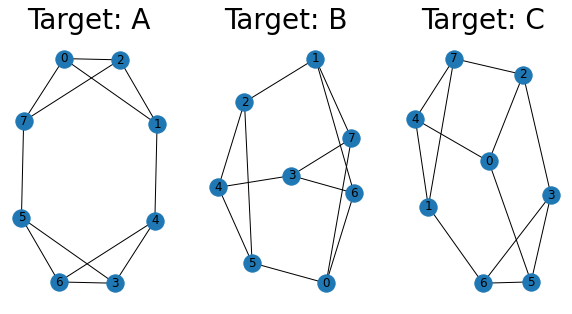

In [ ]:
gallery(train_set[:3], labels=Label()[:3], max_fig_size=(10,5))

### 💻**Task 3.2:** Think of a feature augmentation procedure that can increase the expressive power of GIN. Is GIN + Feature Augmentation better than GIN on the synthetic task? Explain your results. (1 Mark)

How can you augment the initial graph features with additional information about the graph that could lead to higher discriminativity when applying a GIN model on top? 

In [ ]:
def cycle_augmentation(graph):
  nodes=graph.num_nodes
  edges=graph.edge_index.shape[1]
  # print(edges.shape)
  cycle=edges-nodes+1
  cycle_matrix=cycle*torch.ones((graph.x.shape[0],1))
  augmented_feature=torch.cat([graph.x,cycle_matrix],dim=1)
  return augmented_feature

In [ ]:
cycle_augmentation(train_set[0])

tensor([[1., 5.],
        [1., 5.],
        [1., 5.],
        [1., 5.],
        [1., 5.],
        [1., 5.],
        [1., 5.],
        [1., 5.]])

In [ ]:
# CODE HERE =============
# Implement GIN with Feature Augmentation
class GIN(nn.Module):
    """ 
    A Graph Neural Network containing GIN layers 
    as in https://arxiv.org/abs/1810.00826 
    The readout function used to obtain graph-lvl representations
    aggregate pred from multiple layers (as in JK-Net)

    Args:
    input_dim (int): Dimensionality of the input feature vectors
    output_dim (int): Dimensionality of the output softmax distribution
    num_layers (int): Number of layers
    """
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers=2, eps=0.0, \
                 molecular=True):
        super(GIN, self).__init__()
        self.num_layers = num_layers 
        self.molecular = molecular
        # nodes in ZINC dataset are characterised by one integer (atom category)
        # we will create embeddings from the categorical features using nn.Embedding
        if self.molecular:
            self.embed_x = Embedding(28, hidden_dim)
        else:
            self.embed_x = Linear(input_dim, hidden_dim)

        # ============ YOUR CODE HERE =============
        # should be the same as before (an nn.ModuleList of GINLayers)
        # self.layers = nn.ModuleList()
        self.layers = [GINLayer(hidden_dim, hidden_dim, hidden_dim, eps) for _ in range(num_layers-1)]
        self.layers += [GINLayer(hidden_dim, output_dim, hidden_dim, eps)]
        self.layers = nn.ModuleList(self.layers)

        # layer to compute prediction from the concatenated intermediate representations
        # self.pred_layers = scatter_sum(self.embed_x, 1)
        self.pred_layers = SimpleMLP(hidden_dim, output_dim)
        # self.pred_layers = scatter_sum(output_dim, 1, dim=0)
        # =========================================

    def forward(self, graph):
        
        adj_sparse = graph.get_adjacency_matrix()
        # print(graph.y)
        for i in range(len(graph.y)):
          graph.y[i]=i/len(graph.y)



        if self.molecular:
            x = self.embed_x(graph.x.long()).squeeze(1)
        else:
            x = self.embed_x(graph.x)
        # print(graph.y)

        # ============ YOUR CODE HERE ============= 
        # perform the forward pass with the new readout function  
        for i in range(self.num_layers - 1):
            x = self.layers[i](x, adj_sparse)
            x = F.relu(x)
        # x = self.layers[-1](x, adj_sparse)
        x = self.pred_layers(x)
        y_hat = scatter_sum(x, graph.batch.type(torch.int64), dim=0)
        # =========================================
        # return also the final node embeddings (for visualisations)
        return y_hat, x 

In [ ]:
# CODE HERE =============
# Implement GIN with Feature Augmentation
class GIN(nn.Module):
    """ 
    A Graph Neural Network containing GIN layers 
    as in https://arxiv.org/abs/1810.00826 
    The readout function used to obtain graph-lvl representations
    aggregate pred from multiple layers (as in JK-Net)

    Args:
    input_dim (int): Dimensionality of the input feature vectors
    output_dim (int): Dimensionality of the output softmax distribution
    num_layers (int): Number of layers
    """
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers=2, eps=0.0, \
                 molecular=True):
        super(GIN, self).__init__()
        self.num_layers = num_layers 
        self.molecular = molecular
        # nodes in ZINC dataset are characterised by one integer (atom category)
        # we will create embeddings from the categorical features using nn.Embedding
        if self.molecular:
            self.embed_x = Embedding(28, hidden_dim)
        else:
            self.embed_x = Linear(input_dim, hidden_dim)

        # ============ YOUR CODE HERE =============
        # should be the same as before (an nn.ModuleList of GINLayers)
        # self.layers = nn.ModuleList()
        self.layers = [GINLayer(hidden_dim, hidden_dim, hidden_dim, eps) for _ in range(num_layers-1)]
        self.layers += [GINLayer(hidden_dim, output_dim, hidden_dim, eps)]
        self.layers = nn.ModuleList(self.layers)

        # layer to compute prediction from the concatenated intermediate representations
        # self.pred_layers = scatter_sum(self.embed_x, 1)
        self.pred_layers = SimpleMLP(hidden_dim, output_dim)
        # self.pred_layers = scatter_sum(output_dim, 1, dim=0)
        # =========================================

    def forward(self, graph):

        
        adj_sparse = graph.get_adjacency_matrix()
        # print(graph.y)
        for i in range(len(graph.y)):
          graph.y[i]=i/len(graph.y)



        if self.molecular:
            x = self.embed_x(cycle_augmentation(graph).long()).squeeze(1)
            print('hhhh',x.shape)
        else:
            x = self.embed_x(cycle_augmentation(graph))
            print('gggggg',x.shape)
        # print(graph.y)

        # ============ YOUR CODE HERE ============= 
        # perform the forward pass with the new readout function  
        for i in range(self.num_layers - 1):
            x = self.layers[i](x, adj_sparse)
            x = F.relu(x)
        # x = self.layers[-1](x, adj_sparse)
        x = self.pred_layers(x)
        y_hat = scatter_sum(x, graph.batch.type(torch.int64), dim=0)
        # =========================================
        # return also the final node embeddings (for visualisations)
        return y_hat, x 

In [ ]:
model_gin = GIN(input_dim=batch_zinc.x.size()[-1], output_dim=1, hidden_dim=HIDDEN_DIM, num_layers=4, eps=0.1)
out, _ = model_gin(batch_zinc)
print(out.detach().numpy())

#Train GIN model:
train_stats_gin_zinc = train_eval(model_gin, train_zinc_dataset, val_zinc_dataset, 
                                  test_zinc_dataset, loss_fct=F.mse_loss, 
                                  metric_fct=F.mse_loss, print_every=150)
plot_stats(train_stats_gin_zinc, name='GIN_ZINC', figsize=(5, 10))

IndexError: ignored

In [ ]:
# ============ YOUR CODE HERE =============
# Implement GIN with Feature Augmentation
# =========================================

In [ ]:
# ============ YOUR CODE HERE =============
# Evaluate your model on this new dataset against GIN.
# =========================================

### 💻**Task 3.3:** Prove mathematically that GIN + Feature Augmentation is indeed strictly more powerful than vanilla GIN. (1 Mark)

Following our definition of more powerful, we will adopt a two steps approach. Firstly, prove that your model is at least as powerful as GIN (i.e. it can also distiguish all pairs that GIN can distinguish) and, secondly, that your model can also distinguish additional pairs compared to GIN. 

Let us write the local aggregation performed by GIN more abstractly as $x_v^{k+1} = f_{\text{GIN}}(x_v^k, \{\{ x_u^k \mid u \in \mathcal{N}(v)\}\})$, where $\{\{ ... \}\}$ denotes a multiset and $x_v^k$ the feature of node $v$ at layer $k$. Notice that GIN is maximally expressive when $f_{\text{GIN}}$ is injective because it allows it to map different neighbourhoods to different embeddings, which leads to higher discriminative power. We will use as a fact (i.e. no proof) that there exist a set of parameters that make $f_{\text{GIN}}$ injective. 

Thus, for the first part of the proof, prove the following steps:

**Step 1:** Denote by $x_v^k$ the features of node $v$ at layer $k$ of a GIN model with injective layers. Similarly, denote by $y_v^k$ the features of a second GIN model with injective layers and augmented features at $k=0$. Prove by induction that for any two nodes $v, u$ from two arbitrary graphs, if $y_v^k = y_u^k$, then $x_v^k = x_u^k$. 

**Step 2:** Prove that for any two graphs $\mathcal{G_1}, \mathcal{G_2}$, if $\{\{x_v^{k} \mid  v \in V_{\mathcal{G_1}} \}\} \neq \{\{x_u^{k} \mid  u \in V_{\mathcal{G_2}}\}\}$, then $\{\{y_v^{k} \mid  v \in V_{\mathcal{G_1}} \}\} \neq \{\{y_u^{k} \mid  u \in V_{\mathcal{G_2}}\}\}$. 

***Proof.*** Add you proof here



To proof this I will base on the fact that is built on injective function and comparison between two graphs.

* Let suppose that we have two nodes $u$ and $v$ that come from two different graphs.
* Let also suppose that our GIN Layer has injective function that is mapping one node by one node from last layer to the next layer.

* Let consider $f^k_{u+}$ as feature after doing augmentation for first graph that contains node $u$ at layer $k$.

* Let consider also $f^k_{v+}$ as feature after doing augmentation on the graph that contains node $v$ at layer $k$.

Now, if after doingfeature augmentation we find that $f^k_{u+}=f^k_{v+}$ this implies that the feature $X$ at layer $k$ before doing augmentation were the same, $X^k_u=X^k_v$.

## To prove it by recurrence:

* Let consider function $g_k$ as injective function at layer $k$.
* At the zeros layer $k=0$ which means $f^0_{u+}=f^0_{v+}$
* Due to the fact that we do can do augmentation by concatenating the node features embedding.
The augmented feature at $0^{th}$ layer  will be:

$f^0_{u+}=concat([X^0_u,x_u])$ and $f^0_{v+}=concat([X^0_v,x_v])$

If the data obtained after doing augmentation are the same, this implies that the data before augmentation were the same.

* $f^0_{u+}=f^0_{v+}\implies X^0_u=X^0_v\; \&\; x_u=x_v$.

Therefore, $X^0_u=X^0_v$.

# Suppose we have the number of layer $n$ at any given layer $k<n$.

If the augmented data are the same to both graphs it implies that the data before augmentation were also the same.

* $f^k_{u+}=f^k_{v+}\implies X^k_u=X^k_v$.

By induction we have to think about the next layer.

If the augmented data are also still the same, we are going to prove that also the data were the same before doing feature augmentation.
* $f^{k+1}_{u+}=f^{k+1}_{v+}\implies X^{k+1}_u=X^{k+1}_v$.


* $f^{k+1}_{u+}=f^{k+1}_{v+}$
** $\implies g_{n+1}(f^k_{u+})=g_{n+1}(f^k_{v+})$
** $\implies f^k_{u+}=f^k_{v+}$ due to the fact that $g_{n+1}$ is injective function.
Now we can draw our hypothesis that

$f^{k}_{u+}=f^{k}_{v+}\implies X^{k}_u=X^{k}_v$

If is the case, then we can conclude that:

$g_{n+1}(X^{k}_u)=g_{n+1}(X^{k}_v)\implies X^{k+1}_u=X^{k+1}_v$

Now we are able to see that if the feature after augmentation are the same it implies that the data before were the same.

* $f^k_{u+}=f^k_{v+}\implies X^k_u=X^k_v$.


# 2.To reduce the symbols let me have these representation:

* Let me represent the embedding at layer $k$ of both graphs $G_1$ and $G_2$ be 
$h_{k1}=\{\{\ x^k_v| v\in V_{G_1}\}\}$ and $h_{k2}=\{\{\ x^k_u| u\in V_{G_2}\}\}$

* Let me represent the embedding at layer $k$ of both graphs $G_1$ and $G_2$ after doing feature augmentation be 

$g_{k1}=\{\{\ f^k_{v+}| v\in V_{G_1}\}\}$ and $g_{k2}=\{\{\ f^k_{u+}| u\in V_{G_2}\}\}$

* Objective is to prove that if the embedding before doing augmentation also after doing augmentation it will keep to be different.

$h_{k1}\ne h_{k2}\implies g_{k1}\ne g_{k2}$

# To prove this by recurrence, we start at $0^{th}$ layer:

* Let's suppose that $h_{01}\ne h_{02}$, this implies that there are some features which are in one graph not in another since they have the same number of nodes.
Mathematically, $∃X^0_v \; \& X^0_u \;s.t\; X^0_v\notin h_{k2} \; \& X^0_u\notin h_{k1} $

Then $f^0_{v+}=concat([X^0_v,x_v])\notin h_{02}$ and $f^0_{v+}=concat([X^0_u,x_u])\notin h_{01}$. This implies that $g_{01}\ne g_{02} $.


Now, if we are at the layer $k$ in the network of $n$ layer given that $k\le n$ where the embeddings are different $h_{k1}\ne h_{k2}$ this implies that after doing augmentation $g_{k1}\ne g_{k2}$.

*If embeddings at the next layer $k+1$ are different let prove that also the data after feature augmentation will be different.

* Once $h^{n+1}_1\ne h^{n+1}_2$ there exists $v\in V_{G1}$ and $u\in V_{G2}$ such that $X^{n+1}_u\notin g^{n+1}_1$ and $X^{n+1}_v\notin g^{n+1}_2$.

* Since $X^{n+1}_u=f^{n+1}_{inject}(X^n_u)$ and $X^{n+1}_v=f^{n+1}_{inject}(X^n_v)$ while $X^{n+1}_u\notin h^{n+1}_1$ and $X^{n+1}_v\notin h^{n+1}_2$.

This will inform that $X^{n}_u\notin h^{n}_1$  and $X^{n}_v\notin h^{n}_2$ then $h^{n}_1\ne h^{n}_2$.

Now we bring hypothesis that if we have $g^n_1\ne g^n_2$ there exist $u^\prime\notin V_{G2}$ and $v^\prime \notin V_{G1}$ such that $f^n_{v^\prime+}\notin g^n_2$ and $f^n_{u^\prime+}\notin g^n_1$.

which implies that 
$f^{n+1}_{u^\prime+}= f^{n+1}_{inject}\large( f^{n}_{u^\prime+}\large)\notin g^{n+1}_2$ and $f^{n+1}_{v^\prime+}= f^{n+1}_{inject}\large( f^{n}_{v^\prime+}\large)\notin g^{n+1}_1$ because $f^{n+1}_{inject}$ is an injective function.

* Finally, we get that $g^{n+1}_1\ne g^{n+1}_2$ which shows us that if $h_{n1}\ne h_{n2}$ implies that $g^{n}_1\ne g^{n}_2$.















Now, let us test the model you proposed above in a real-world setting. 

### 💻**Task 3.4:** Evaluate GIN + feature augmentation on ZINC and compare your results to the vanilla GIN. Is your model doing better? In either case, explain the results you obtain. (0.5 Marks)

In [ ]:
# ============ YOUR CODE HERE =============
# Evaluate your model on ZINC
# =========================================


### 💻**Task 3.5:** Beyond message passing (2.5 Marks)

We will end this practical with an open-ended task for extra points. 

So far, we have only looked at increasing the expressive power by adding additional features to the initial features of a graph. An alternative is to modify the computational graph of the model. In other words, we could perform computations that go beyond the traditional message passing approach that you have seen in the lectures and in this practical, which could ultimately lead to improved discriminative power. 

1.   Design a model that is strictly more expressive than GIN by going beyond the regular message passing between nodes.  
2.   Prove that your model is indeed strictly more powerful than GIN.
3.   Prove and write a test to check that the layers of your model are permutation equivariant. 
4.   Evaluate your model on ZINC. How does it compare to the GIN and GIN + Augmented Features models from above? 
5.   Discuss the computational complexity of your solution? How does it compare with the complexity of message passing approaches? Can the complexity of your solution be improved? 



In [ ]:
# !pip install spektral

In [ ]:
class Graph(object):
    def __init__(self, edge_index, x, y):
        """ Graph structure 
            for a mini-batch it will store a big (sparse) graph 
            representing the entire batch
        Args:
            x: node features  [num_nodes x num_feats]
            y: graph labels   [num_graphs]
            edge_index: list of edges [2 x num_edges]
        """
        self.edge_index = edge_index
        self.x = x.to(torch.float32)
        self.y = y
        self.num_nodes = self.x.shape[0]

    #ignore this for now, it will be useful for batching
    def set_batch(self, batch):
        """ list of ints that maps each node to the graph it belongs to
            e.g. for batch = [0,0,0,1,1,1,1]: the first 3 nodes belong to graph_0 while
            the last 4 belong to graph_1
        """
        self.batch = batch

    # this function return a sparse tensor
    def get_adjacency_matrix(self):
        """ from the list of edges create 
        a num_nodes x num_nodes sparse adjacency matrix
        """
        return torch.sparse.LongTensor(self.edge_index, 
                              # we work with a binary adj containing 1 if an edge exist
                              torch.ones((self.edge_index.shape[1])), 
                              torch.Size((self.num_nodes, self.num_nodes))
                              )



In [ ]:
import networkx as nx
H=nx.Graph()

In [ ]:
def edge_generator(edge_collection):
  print(type(edge_collection))
  edges=list(edge_collection)
  collection=set()
  for first in edges:
    collection.add((first[0],first[1]))
    collection.add((first[1],first[0]))
  result=sorted([list(value )for value in collection],key=lambda x:x[0])

  return torch.tensor(result).T


In [ ]:
def graph_collection(n_nodes):
  graph_list=[]
  for i in range(n_nodes):
    nodes_n=np.random.randint(3,6)

    new_grapg=nx.random_regular_graph(3,nodes_n)
    index_edge=edge_generator(list(new_grapg.edges.data()))
   
    x=torch.randn(nodes_n,1)
    y=np.random.randint(1,2)

    graph=Graph(x=x,edge_index=index_edge,y=y)
    graph_list.append(graph)

  return graph_list




In [ ]:
# new_g=graph_collection(4)


In [ ]:
HIDDEN_DIM=3

In [ ]:
# model_simple_gin=SimpleGIN(input_dim=new_g[0].x.size()[-1], output_dim=1, hidden_dim=HIDDEN_DIM, num_layers=4, eps=0.1)

In [ ]:
dataset[0].x

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [ ]:
a=[1,2,3,4,57]
import random

In [ ]:
random.shuffle(a)
a

[2, 1, 4, 3, 57]